# Previously we have considered how to work with Time Series data by ARIMA and ML techniques
# Here and now we are going to find connections and create approach to predict Q2 values depending on pumps, sprinkles and HE fouling effects

In [1293]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [1294]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import (
    TimeSeriesSplit, cross_validate, 
    KFold, train_test_split,
    ShuffleSplit
)
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree

from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from joblib import dump, load

In [1295]:
# this are periods when 1,2,3,4 HEs were under operation
time_periods = [
    ("2022-09-05","2022-09-09"), ("2022-09-12","2022-09-13"),
    ("2022-10-17","2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
    ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
    ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23"), ("2023-01-10","2023-01-13"), 
    ("2023-01-16","2023-01-19"), ("2023-01-24","2023-01-27"), ("2023-01-31","2023-02-03"), 
    ("2023-02-07","2023-02-09"), ("2023-02-13","2023-02-17"), ("2023-02-28","2023-03-03"), 
    ("2023-03-06","2023-03-07"), ("2023-03-09","2023-03-10"), ("2023-03-14","2023-03-17"),
    ("2023-03-27","2023-03-31"), ("2023-04-03","2023-04-07"), ("2023-04-10","2023-04-14"),
#     ("2023-04-17","2023-04-21"), ("2023-05-02","2023-05-05"), ("2023-05-08","2023-05-12"),
#     ("2023-05-15","2023-05-19"), ("2023-05-22","2023-05-26"), ("2023-05-29","2023-06-02"),
#     ("2023-06-05","2023-06-09"),
]

time_periods2 = [
    ("2021-09-06","2021-09-10"), ("2021-09-13","2021-09-17"), ("2021-09-20","2021-10-01"),
    ("2021-10-04","2021-10-08"), ("2021-10-11","2021-10-15"), ("2021-11-08","2021-11-12"),
    ("2021-11-15","2021-11-19"), ("2021-11-22","2021-11-26"), ("2021-11-29","2021-12-03"),
    ("2021-12-07","2021-12-03"), ("2021-12-13","2021-12-17"), ("2021-12-20","2021-12-24"),
    ("2022-01-18","2022-01-21"), ("2022-01-24","2022-01-26"), ("2022-02-01","2022-02-04"),
    ("2022-02-08","2022-02-11"), ("2022-02-14","2022-02-18"), ("2022-02-24","2022-02-25"),
    ("2022-03-01","2022-03-04"), ("2022-03-15","2022-03-18"), ("2022-03-21","2022-03-25"),
    ("2022-03-29","2022-04-01"), ("2022-04-12","2022-04-15"), ("2022-04-18","2022-04-22"),
    ("2022-05-02","2022-05-06"), ("2022-05-09","2022-05-13"), ("2022-05-16","2022-05-20"),
    ("2022-05-23","2022-05-27"), ("2022-06-07","2022-06-10"), ("2022-06-20","2022-06-24"),
    ("2022-06-28","2022-07-01"),
    
]

time_periods3 = [
    ("2020-10-12","2020-10-16"), ("2020-10-21","2020-10-23"), ("2020-10-28","2020-10-30"),
    ("2020-11-11","2020-11-13"), ("2020-11-16","2020-11-20"), ("2020-11-24","2020-11-27"),
    ("2020-12-03","2020-12-04"), ("2020-12-07","2020-12-11"), ("2020-12-16","2020-12-18"), 
    ("2020-12-24","2020-12-25"), ("2020-12-29","2020-12-30"), ("2021-01-12","2021-01-15"),
    ("2021-01-18","2021-01-22"), ("2021-02-01","2021-02-05"), ("2021-02-08","2021-02-12"),
    ("2021-02-15","2021-02-19"), ("2021-03-01","2021-03-05"), ("2021-03-09","2021-03-12"),
    ("2021-03-15","2021-03-19"), ("2021-03-22","2021-03-26"), ("2021-04-01","2021-04-02"),
    ("2021-04-05","2021-04-09"), ("2021-04-05","2021-04-09"), ("2021-04-12","2021-04-16"),
    ("2021-04-20","2021-04-24"), ("2021-04-26","2021-04-30"), ("2021-05-03","2021-05-07"),
    ("2021-05-11","2021-05-15"), ("2021-05-17","2021-05-21"), ("2021-05-24","2021-05-28"),
    ("2021-06-15","2021-06-18"), ("2021-06-21","2021-06-25"), ("2021-06-28","2021-07-02"),
]

In [1296]:
# fc 119,120,121
fcs = [
    ("2021-03-09", "2021-04-12"), ("2021-04-12", "2021-05-11"), ("2021-05-11", "2021-09-20")
]

In [1297]:
time_periods_all = [*time_periods3, *time_periods2, *time_periods]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 315 T1k before HE
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 321 T reactor
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1k
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [1298]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [1299]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [1300]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, ccf

In [50]:
# df = pd.read_excel("rdy_for_fe_121020_to_210423.xlsx", index_col="Timestamp")
# df_nosma = pd.read_excel("rdy_for_fe_121020_to_210423_no_sma.xlsx", index_col="Timestamp")



In [257]:
# 5 min frequency

df_stats = pd.read_excel("rdy_for_stats_121020_090623.xlsx", index_col="Timestamp")

In [241]:
df_stats["HE4_TOP"]

Timestamp
2020-10-13 00:00:00       0.913449
2020-10-13 12:00:00       3.349312
2020-10-13 13:00:00       8.830006
2020-10-13 14:00:00      16.137596
2020-10-13 15:00:00      23.445187
                          ...     
2023-06-09 15:00:00    5471.780678
2023-06-09 16:00:00    5473.188136
2023-06-09 17:00:00    5474.595593
2023-06-09 18:00:00    5476.003051
2023-06-09 19:00:00    5476.882712
Name: HE4_TOP, Length: 7097, dtype: float64

<AxesSubplot: xlabel='QbyIP', ylabel='Count'>

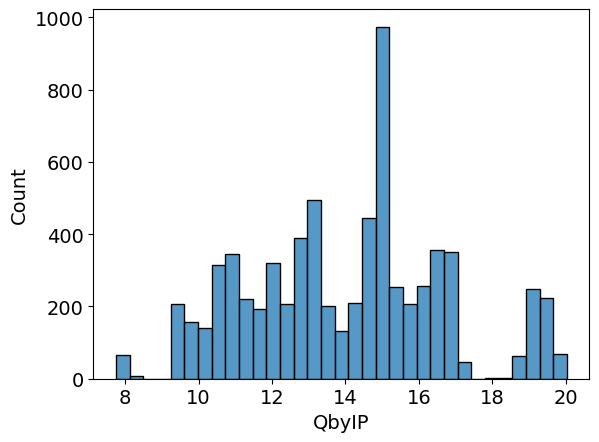

In [242]:
sns.histplot(df_stats["QbyIP"])

<AxesSubplot: xlabel='Q2', ylabel='Count'>

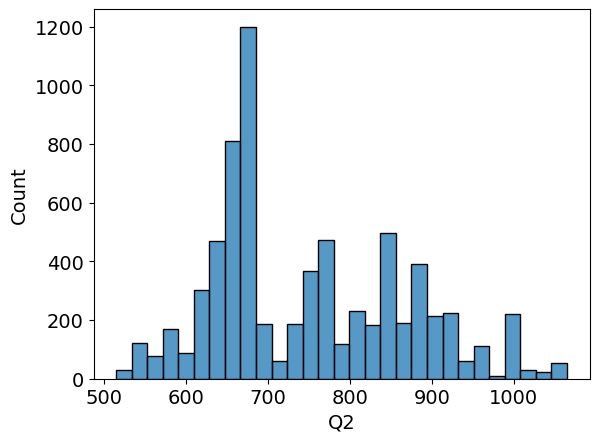

In [243]:
sns.histplot(df_stats["Q2"])

In [244]:
from statsmodels.api import qqplot

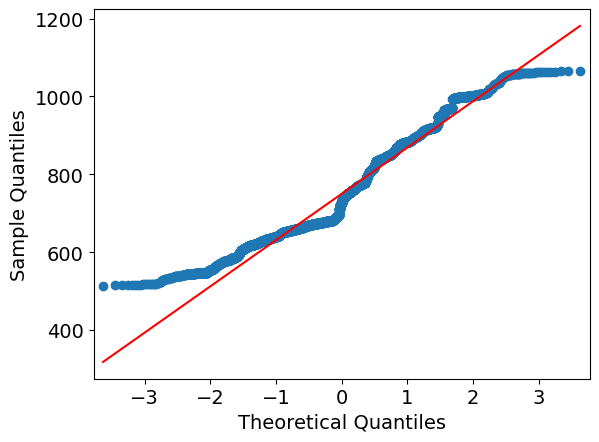

In [245]:
qqplot(df_stats["Q2"].to_numpy(), line ='s')
plt.show()

In [246]:
df_stats_gr = df_stats.groupby(pd.Grouper(freq="2h")).mean()

Timestamp
2020-10-13 00:00:00    14.846935
2020-10-13 12:00:00    14.884088
2020-10-13 14:00:00    14.946375
2020-10-13 16:00:00    14.935981
2020-10-13 18:00:00    14.937355
                         ...    
2023-06-09 10:00:00    12.434544
2023-06-09 12:00:00    12.413073
2023-06-09 14:00:00    12.360581
2023-06-09 16:00:00    12.130565
2023-06-09 18:00:00    12.082479
Name: QbyIP, Length: 1124, dtype: float64


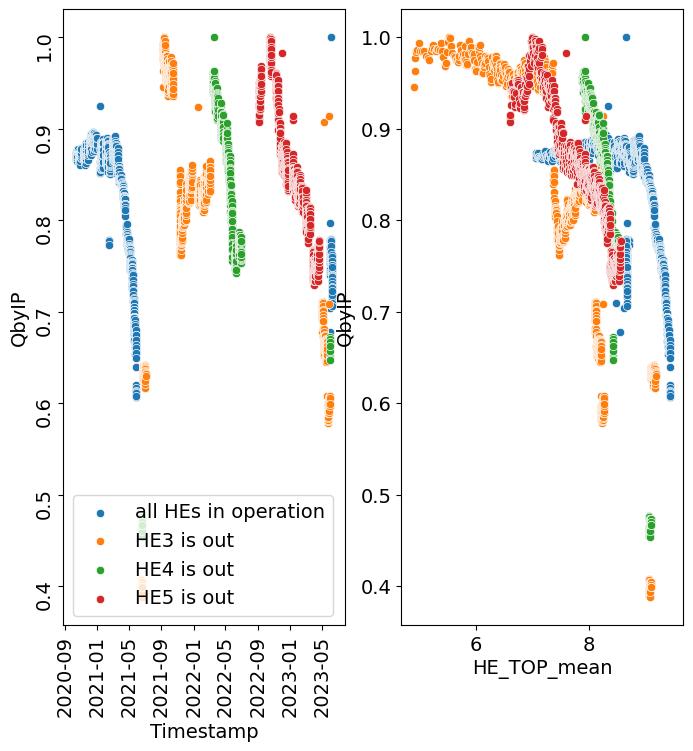

In [247]:

fig, axs = plt.subplots(1,2, figsize=(8,8))

qbyip = df_stats_gr["QbyIP"]

qbyip_all = qbyip[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
].dropna(axis=0)
qbyip3 = qbyip[df_stats_gr["HE3_status"] == 0].dropna(axis=0)
qbyip4 = qbyip[df_stats_gr["HE4_status"] == 0].dropna(axis=0)
qbyip5 = qbyip[df_stats_gr["HE5_status"] == 0].dropna(axis=0)

print(qbyip_all)

hetop_all = df_stats_gr[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
]["HE_TOP_mean"].dropna(axis=0)
hetop3 = df_stats_gr[df_stats_gr["HE3_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop4 = df_stats_gr[df_stats_gr["HE4_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop5 = df_stats_gr[df_stats_gr["HE5_status"] == 0]["HE_TOP_mean"].dropna(axis=0)


sns.scatterplot(qbyip_all / qbyip_all.max(), ax=axs[0], label="all HEs in operation")
sns.scatterplot(qbyip3 / qbyip3.max(), ax=axs[0], label="HE3 is out")
sns.scatterplot(qbyip4 / qbyip4.max(), ax=axs[0], label="HE4 is out")
sns.scatterplot(qbyip5 / qbyip5.max(), ax=axs[0], label="HE5 is out")
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].max(), ax=axs[0])

sns.scatterplot(x=np.log(hetop_all), y=qbyip_all / qbyip_all.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop3), y=qbyip3 / qbyip3.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop4), y=qbyip4 / qbyip4.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop5), y=qbyip5 / qbyip5.max(), ax=axs[1])

axs[0].tick_params(rotation=90)
# sns.scatterplot(qbyip / df_stats.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1))

# On a first look, all curves have similar trends and no matter what HEs are in operation
# However, the cycles that starts from 0 (HE_TOP_mean) have 2 different trends
# It's quite obvious that each cycle is non-stationry around QbyIP

# I assume that data of winter of 2021 is not clear cuz Tair is hardly reach -5
# However usually it dropsbelow -20 -> absolutly anomaly data
## Data till april of 2021 has dropped

In [248]:
# df_stats = df_stats.loc["2021-04":, :]
df_stats.shape

(7097, 35)

In [249]:
df_stats["HEs_num"] = df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)
df_stats["Q2_HEs_num"] = df_stats["Q2"] / df_stats["HEs_num"]
df_stats["QbyIP_HEs_num"] = df_stats["QbyIP"] / df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)


In [250]:
df_stats.columns

Index(['P2', 'Q2', 'T1aHE', 'T1bHE', 'T2aHE', 'T2aHE1', 'T2aHE2', 'T2aHE3',
       'T2aHE4', 'T2aHE5', 'T2bHE', 'Tair', 'Treactor', 'p21', 'p22', 'p23',
       'p24', 'dt1', 'dt2', 'pumps2', 'dt_circuits_coef',
       'dt_circuits_coef_delta', 'I2mean', 'QbyIP', 'HE1_TOP', 'HE2_TOP',
       'HE3_TOP', 'HE4_TOP', 'HE5_TOP', 'HE1_status', 'HE2_status',
       'HE3_status', 'HE4_status', 'HE5_status', 'HE_TOP_mean', 'HEs_num',
       'Q2_HEs_num', 'QbyIP_HEs_num'],
      dtype='object')

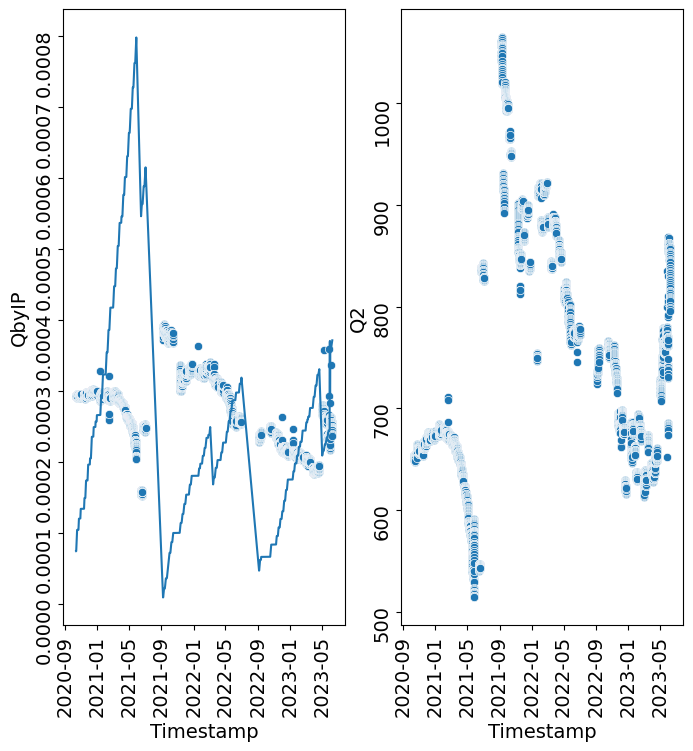

In [251]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
sns.scatterplot(df_stats["QbyIP"]/df_stats_gr["QbyIP"].sum(), ax=axs[0])
sns.lineplot(df_stats["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

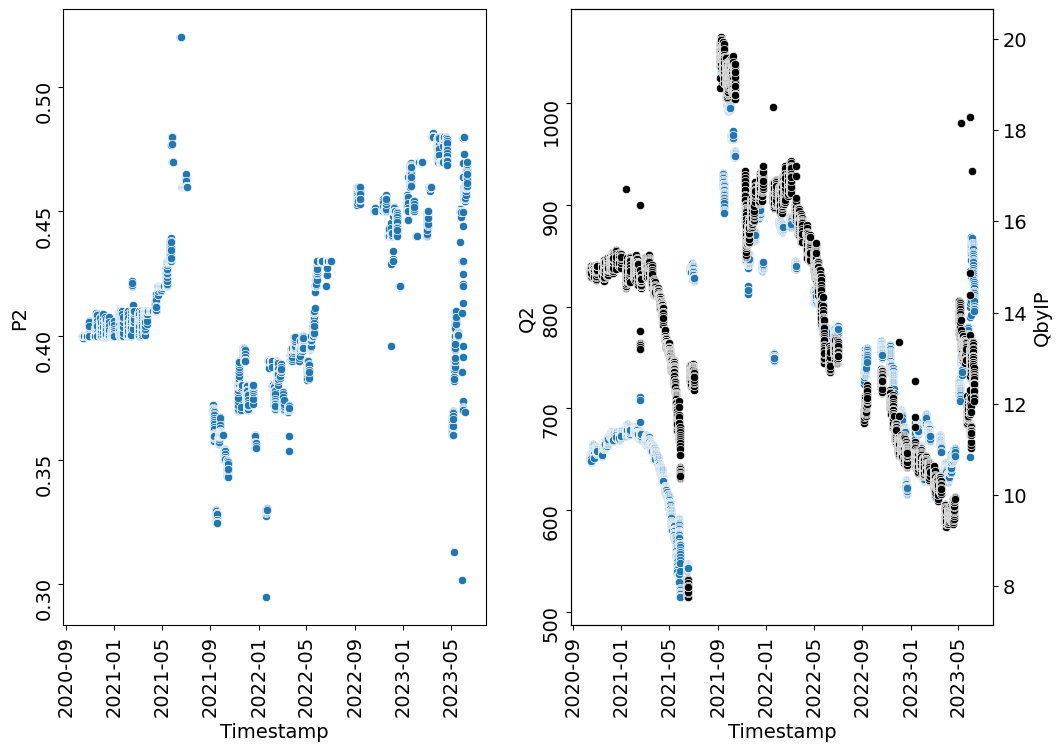

In [252]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(df_stats["P2"], ax=axs[0])
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])
axs11 = axs[1].twinx()
sns.scatterplot(df_stats["QbyIP"], color="black", ax=axs11)
axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

# From diary of maintenance of reactor systems i've learned that nozzles where cleaned only at summer of 2020, 2021. So they status must be taken into account

In [253]:
fe = FeatureEngineering(df_stats)

In [254]:
nozzles_periods = [
    ("2020-10-12", "2021-07-02"), 
    ("2021-09-06", "2023-06-09")
]
df_stats = fe.make_time_onpower_feature(
    time_periods=nozzles_periods,
    feature_name="Nozzles_TOP"
)

[2.72892348e+00 5.45784695e+00 8.18677043e+00 ... 6.30654215e+03
 6.30927108e+03 6.31200000e+03] 2313 2313
[3.21571906e+00 6.43143813e+00 9.64715719e+00 ... 1.53775686e+04
 1.53807843e+04 1.53840000e+04] 4784 4784


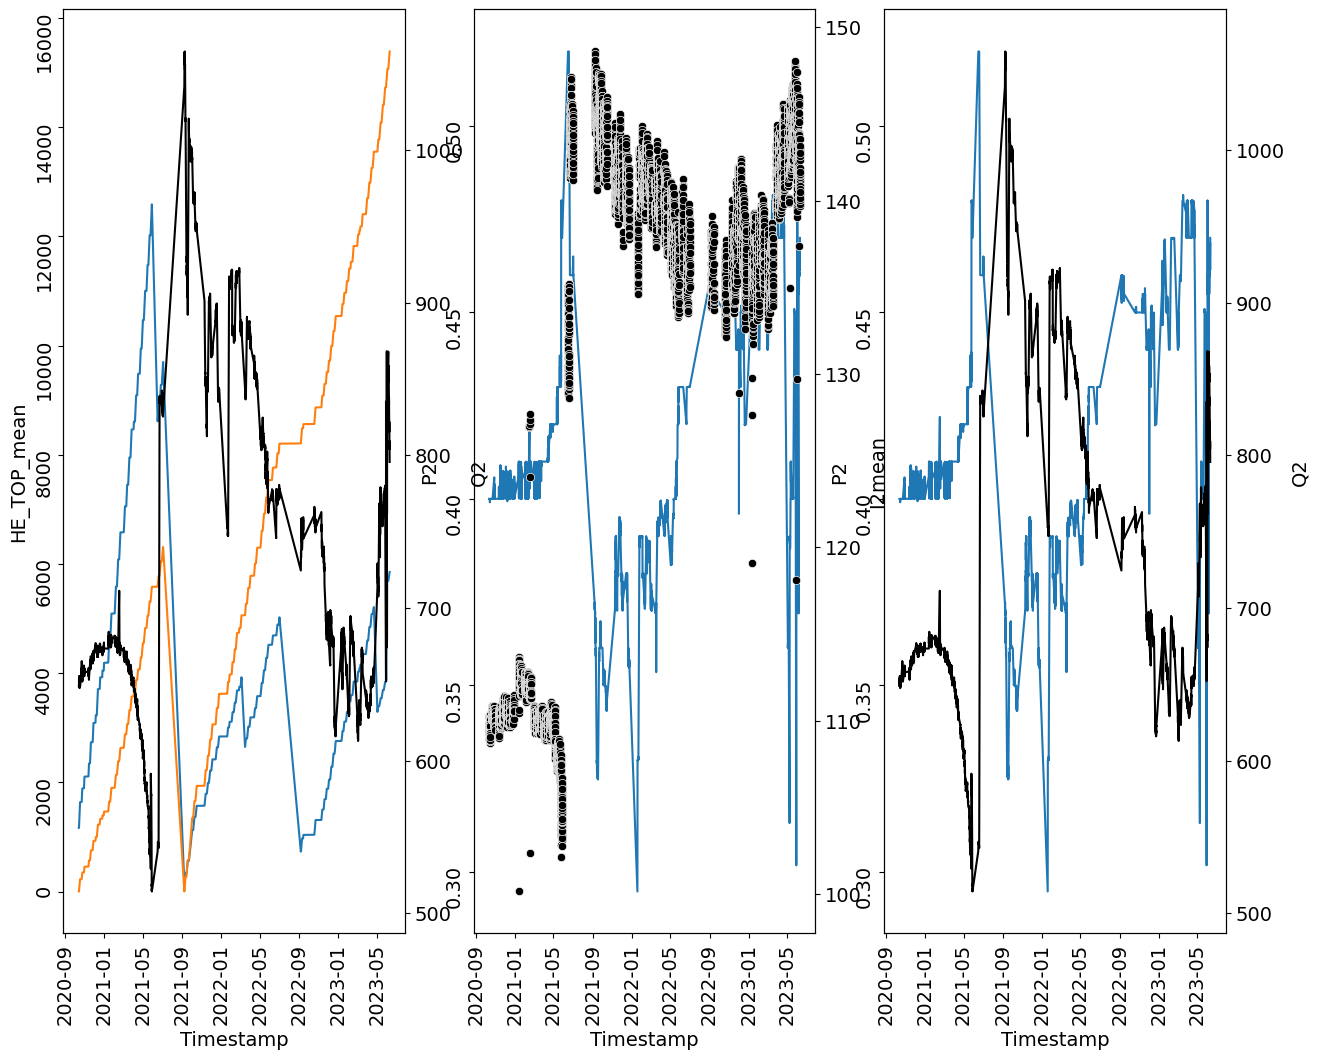

In [255]:
fig, axs = plt.subplots(1,3, figsize=(15,12))
ax0 = axs[0].twinx()
sns.lineplot(df_stats["Q2"], color="black", ax=ax0)
sns.lineplot(df_stats["HE_TOP_mean"], ax=axs[0])
sns.lineplot(df_stats["Nozzles_TOP"], ax=axs[0])

ax1 = axs[1].twinx()
sns.lineplot(df_stats["P2"], ax=axs[1])
sns.scatterplot(df_stats["I2mean"], color="black", ax=ax1)

ax2 = axs[2].twinx()
sns.lineplot(df_stats["P2"], ax=axs[2])
sns.lineplot(df_stats["Q2"], color="black", ax=ax2)

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)
axs[2].tick_params(rotation=90)

In [256]:
df_stats["pumps2"].value_counts()

234.000000     5153
123.000000      784
134.000000      685
124.000000      387
1234.000000      81
475.666667        1
351.800000        1
484.000000        1
400.666667        1
309.000000        1
860.363636        1
511.833333        1
Name: pumps2, dtype: int64

<AxesSubplot: ylabel='QbyIP'>

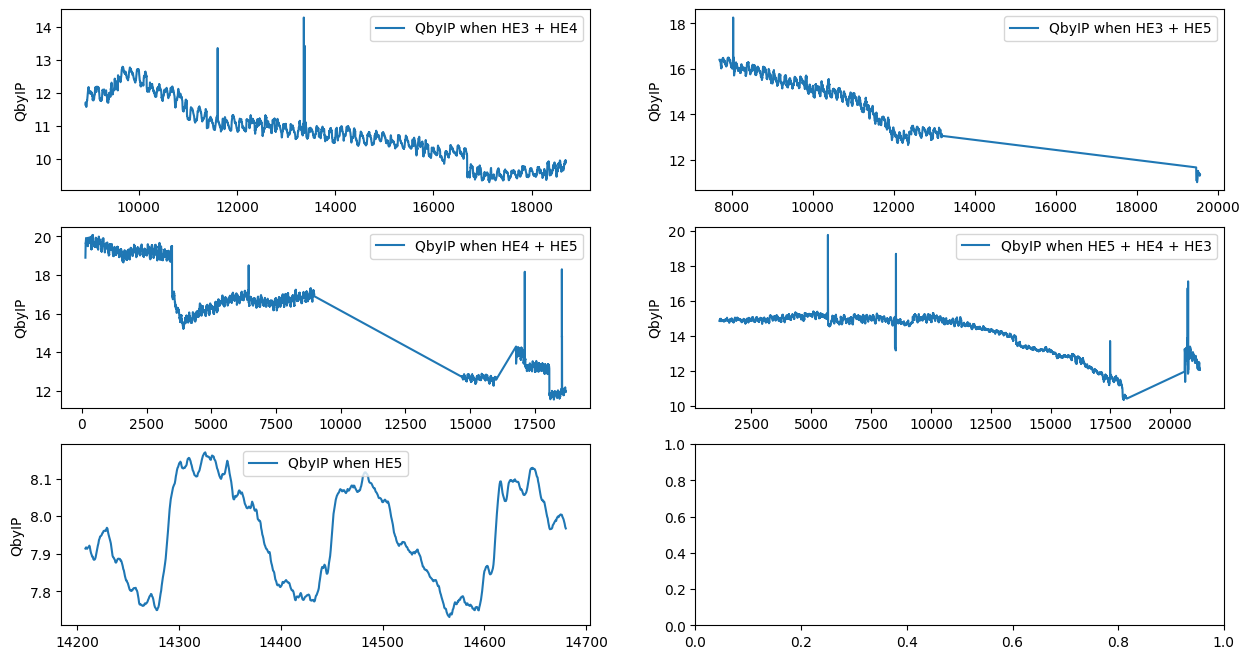

In [69]:
fig, axs = plt.subplots(3,2, figsize=(15,8))
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
#     y=df_stats["QbyIP"],
#     ax=axs[0][0],
#     label="Bare QbyIP"
# )
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5"
)


# As we can see from dependencies above:
## Strong dependencies from what HE operated 
# Need to consider  dependencies to operated pumps  additionally to aquired data

<AxesSubplot: xlabel='Nozzles_TOP', ylabel='QbyIP'>

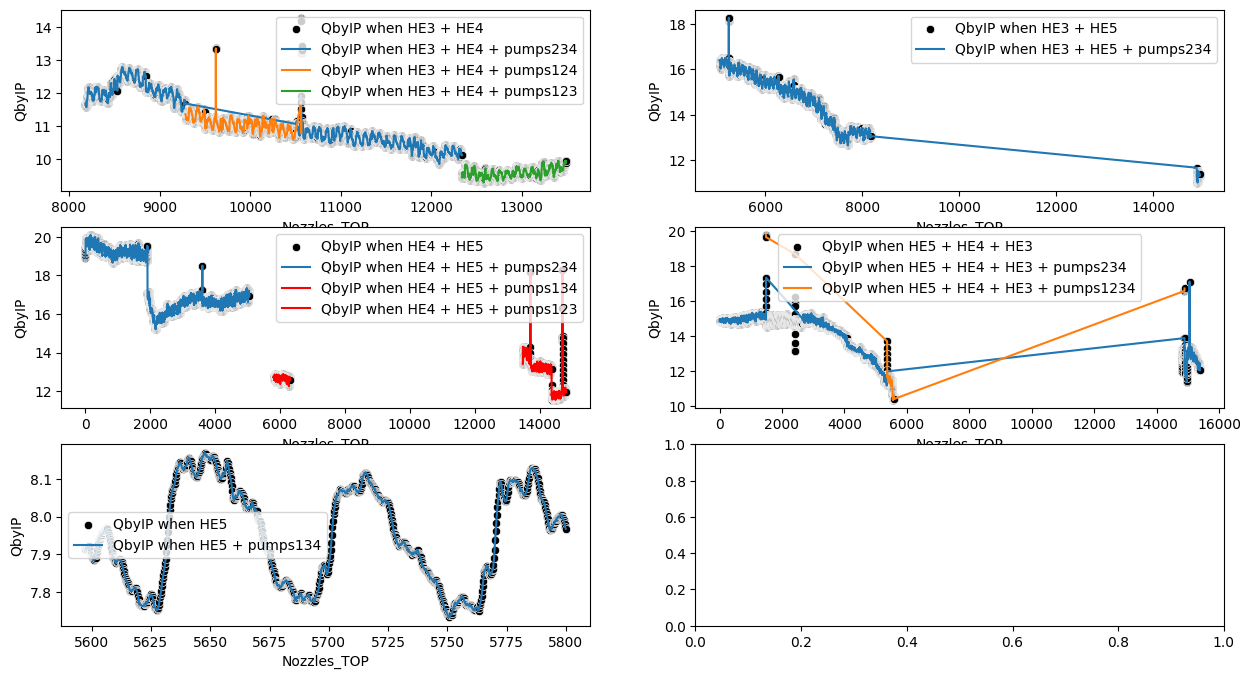

In [70]:
fig, axs = plt.subplots(3,2, figsize=(15,8))

# axs[0][0]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5 + pumps234"
)


# axs[1][0]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps123"
)


# axs[1][1]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="QbyIP when HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5 + pumps134"
)


<AxesSubplot: ylabel='QbyIP'>

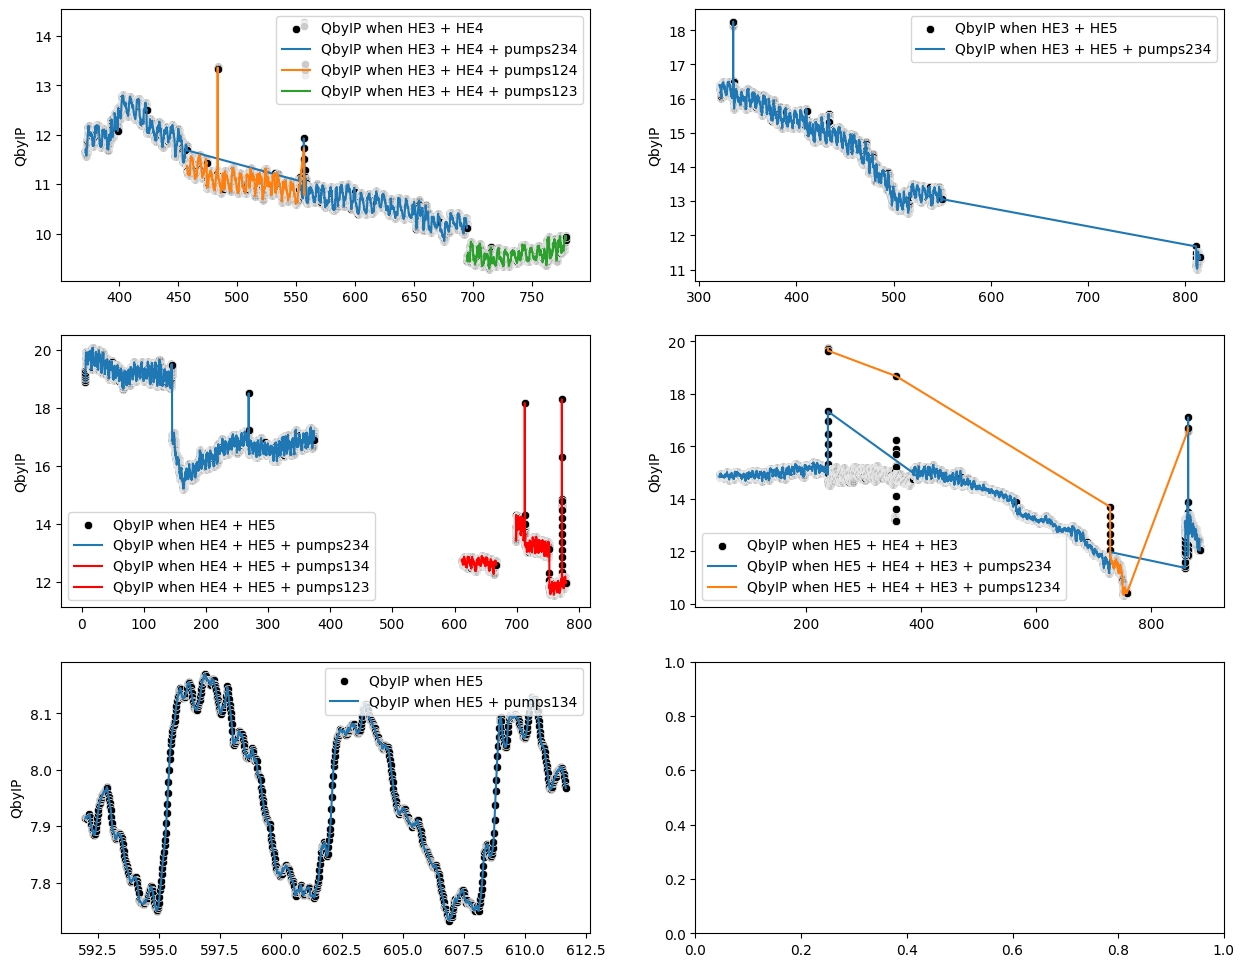

In [71]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5 + pumps234"
)


# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps123"
)


# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="QbyIP when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5 + pumps134"
)

<AxesSubplot: ylabel='Q2'>

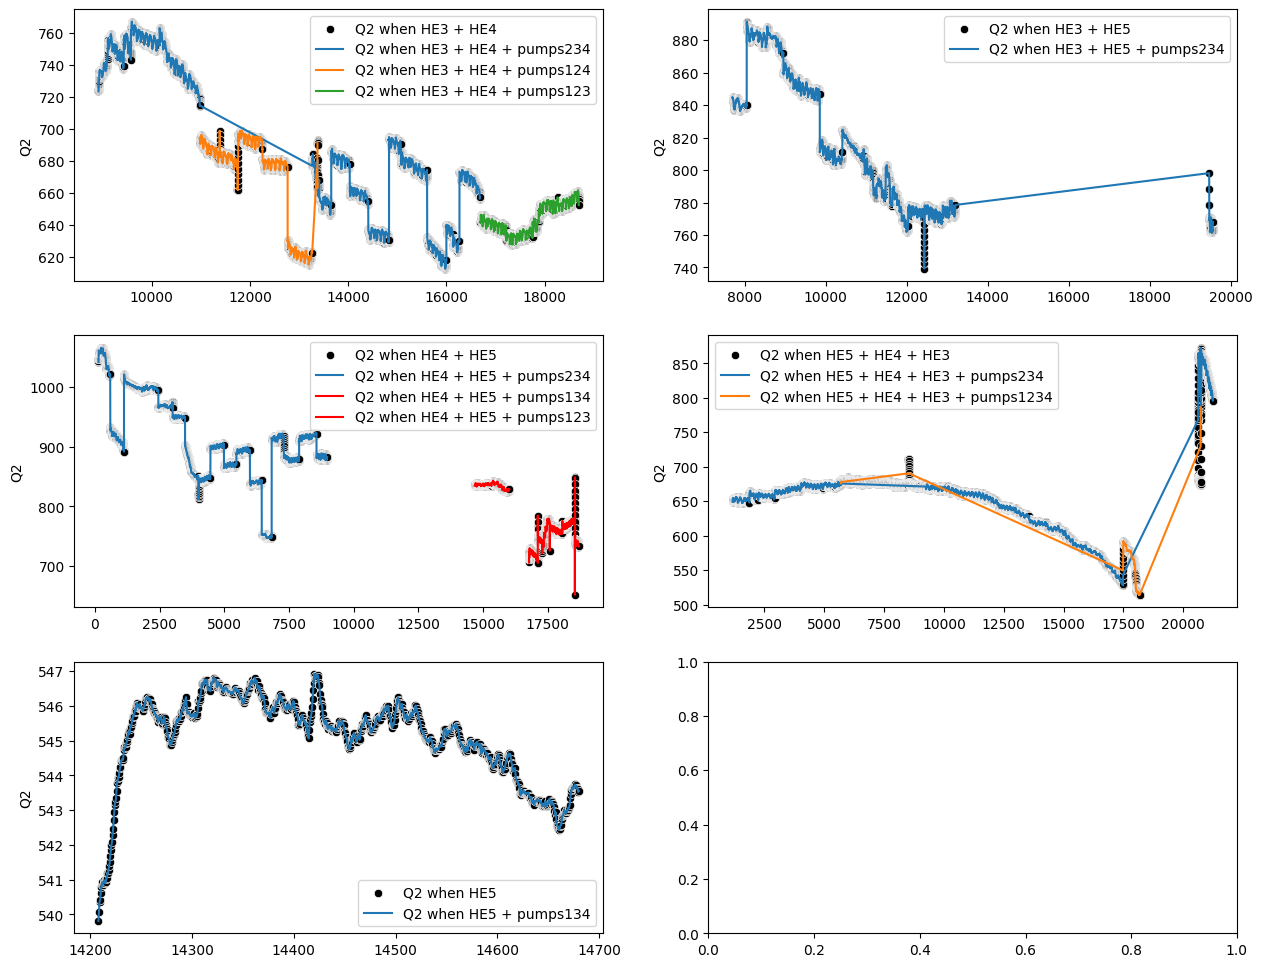

In [72]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"]

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="Q2 when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="Q2 when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="Q2 when HE3 + HE5 + pumps234"
)

# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps123"
)



# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="Q2 when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="Q2 when HE5 + pumps134"
)

<AxesSubplot: xlabel='Nozzles_TOP', ylabel='Q2'>

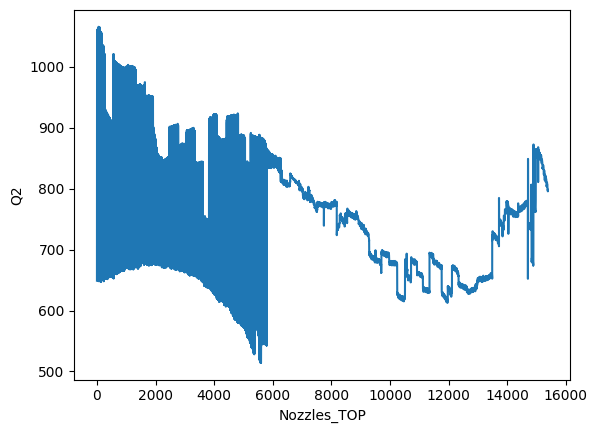

In [73]:
sns.lineplot(x=df_stats["Nozzles_TOP"], y=df_stats["Q2"])

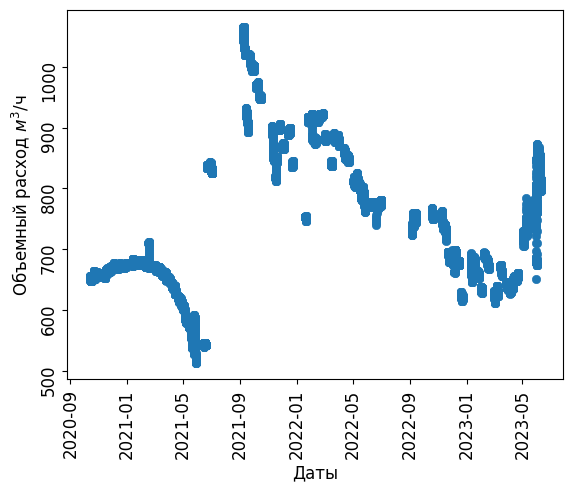

In [74]:
plt.rcParams.update({'font.size': 12})

sns.scatterplot(df_stats.loc[:,"Q2"], edgecolor = None)
plt.ylabel("Объемный расход $м^3$/ч")
plt.xlabel("Даты")
plt.tick_params(rotation=90)

Text(0.5, 0, 'Длительность работы, эфф.суток')

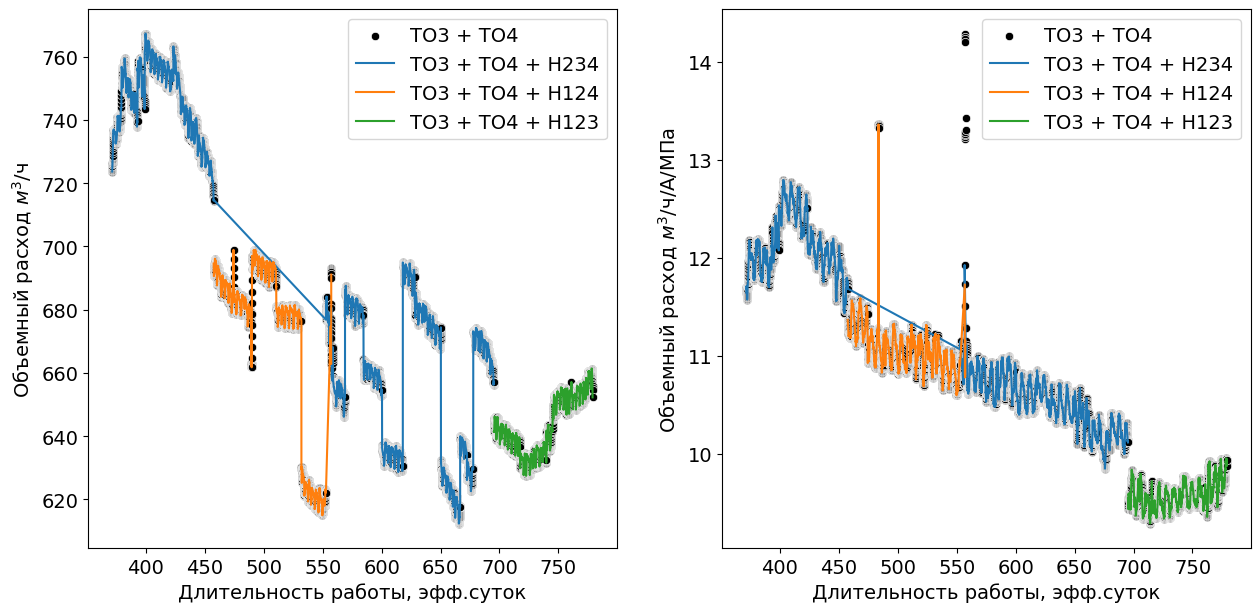

In [75]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н123"
)



sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н123"
)
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Объемный расход $м^3$/ч/А/МПа")
axs[1].set_xlabel("Длительность работы, эфф.суток")

Text(0.5, 0, 'Длительность работы, эфф.суток')

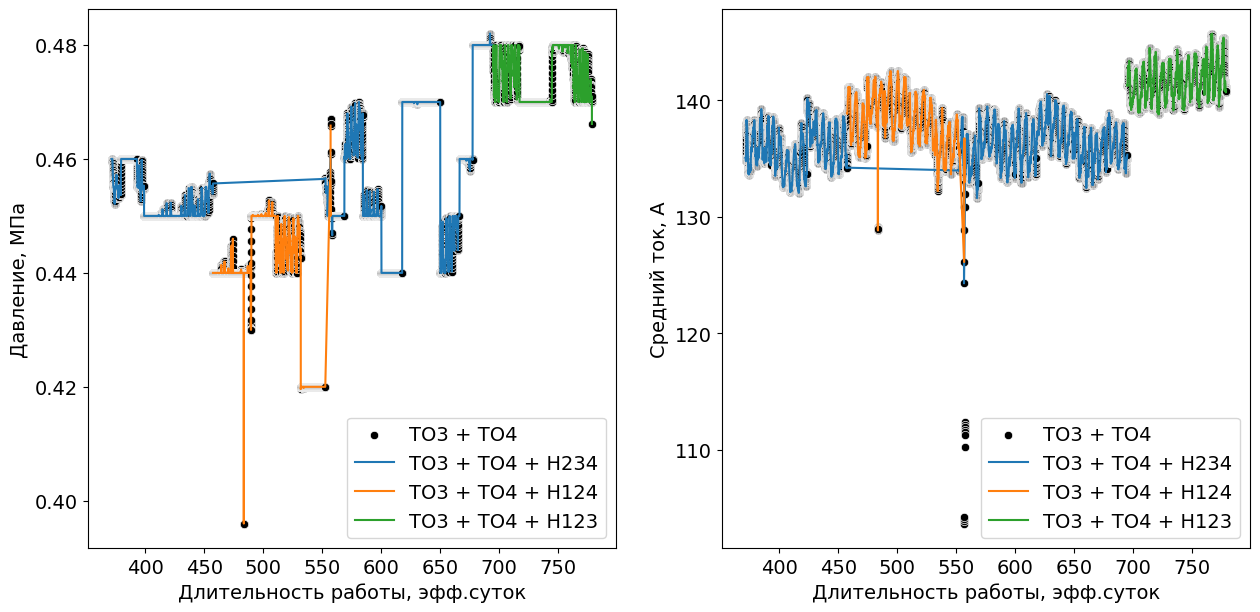

In [76]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))
x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н123"
)


sns.scatterplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н123"
)

axs[0].set_ylabel("Давление, МПа")
axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Средний ток, А")
axs[1].set_xlabel("Длительность работы, эфф.суток")

# plt.tick_params(rotation=90)

(-0.14705852078975568, 0.19747549750252566)

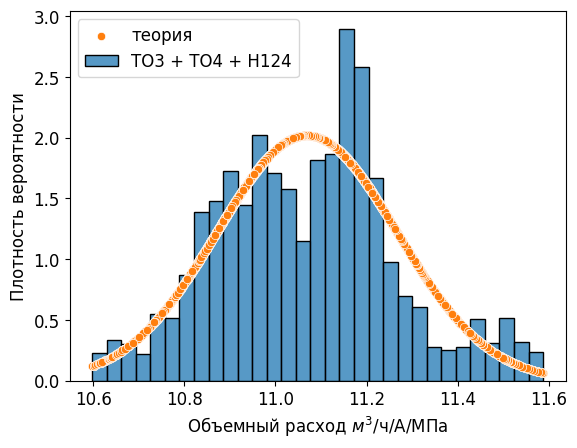

In [77]:
plt.rcParams.update({'font.size': 12})

data = df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["QbyIP"] < 11.7)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Объемный расход $м^3$/ч/А/МПа")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

(-0.839451906829928, 0.03626063034403322)

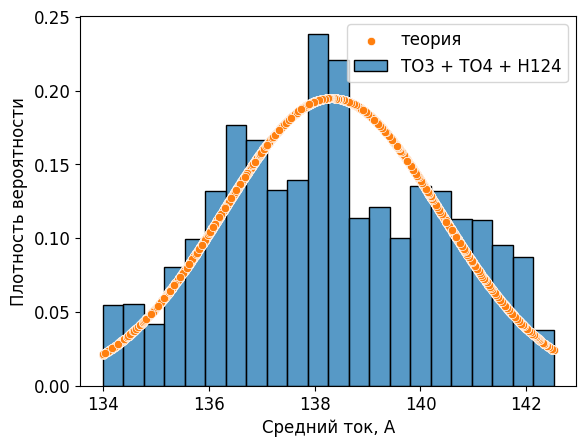

In [78]:
plt.rcParams.update({'font.size': 12})

data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Средний ток, А")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

Text(0, 0.5, 'Вероятность')

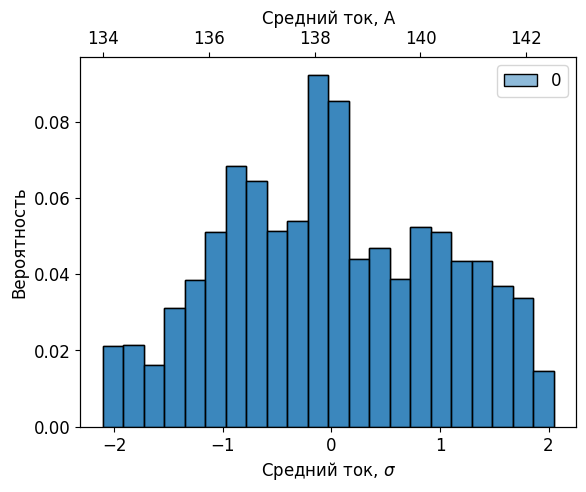

In [79]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
ax2 = ax.twiny()
data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

data_ss = StandardScaler().fit_transform(data.to_numpy().reshape(-1,1))

sns.histplot(
    data_ss,
    stat="probability",
    ax=ax
)
sns.histplot(
    data,
    stat="probability",
    ax=ax2
)

ax2.set_xlabel("Средний ток, А")
ax.set_xlabel("Средний ток, $\sigma$")
ax.set_ylabel("Вероятность")

# After pumps status were added as important feature to describe all dependencies we may consider distribution once again

(-9.540550784050502,
 2.7340642616615946e-16,
 24,
 10385,
 {'1%': -3.4309798427642066,
  '5%': -2.861818354171852,
  '10%': -2.5669181627815387},
 -12536.162866597966)

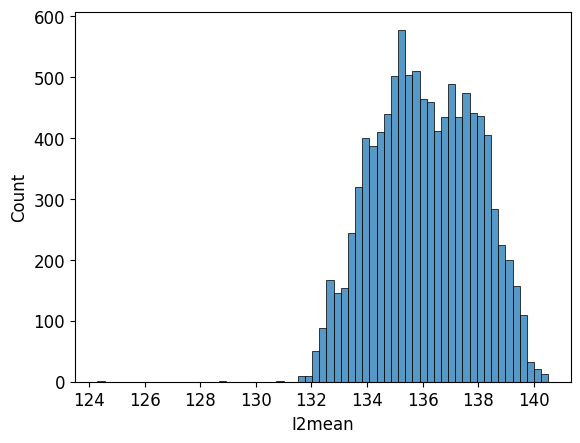

In [80]:
df_he34_p234 = (df_stats[
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ]
    ).dropna()
sns.histplot(
    df_he34_p234["I2mean"]
)

statsmodels.tsa.stattools.adfuller(
    df_he34_p234["I2mean"]
)

<AxesSubplot: >

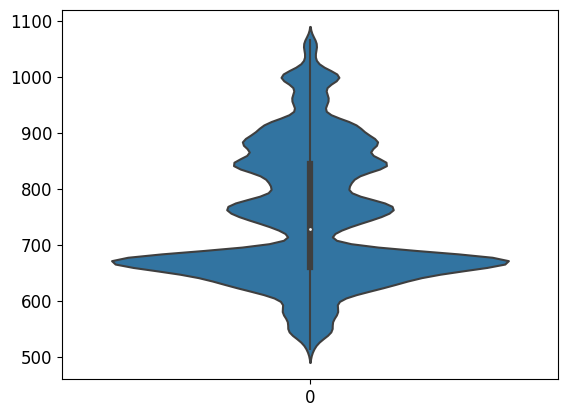

In [81]:
sns.violinplot(df_stats["Q2"])

In [82]:
df_stats["pumps2"].value_counts()

234     58946
123      9155
134      7816
124      4377
1234      981
Name: pumps2, dtype: int64

In [83]:
df_stats_Q2 = df_stats.loc[
    :, 
    [
        "Q2", "P2", "I2mean", "Nozzles_TOP", 
        "HE_TOP_mean","HE3_status",
        "HE4_status", "HE5_status",
        "pumps2",
        "HEs_num"
    ]
]

# df_stats_Q2 = df_stats_undersampled.loc[
#     :, 
#     [
#         "Q2", "P2", "I2mean", "Nozzles_TOP", 
#         "HE_TOP_mean","HE3_status",
#         "HE4_status", "HE5_status",
#         "pumps2",
#         "HEs_num"
#     ]
# ]

In [84]:
df_stats_Q2["pumps2"].value_counts()

234     58946
123      9155
134      7816
124      4377
1234      981
Name: pumps2, dtype: int64

In [85]:
numerical_cols = [
    "Nozzles_TOP","I2mean", "HE_TOP_mean"
]
ct = ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), numerical_cols),
            ("categorical_data", OneHotEncoder(sparse=False), ["pumps2", "HEs_num"])
        ],
        remainder="passthrough"
).set_output(transform="pandas")

In [86]:
# df_stats_Q2 = pd.concat(
#     [
#         df_stats_Q2, 
#         pd.get_dummies(df_stats["pumps2"], prefix="pumps")
#     ], 
#     axis=1
# ) 

In [87]:
df_stats_Q2_heatmap = ct.fit_transform(df_stats_Q2)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [88]:
df_stats_Q2_heatmap.columns

Index(['numerical_data__Nozzles_TOP', 'numerical_data__I2mean',
       'numerical_data__HE_TOP_mean', 'categorical_data__pumps2_123',
       'categorical_data__pumps2_124', 'categorical_data__pumps2_134',
       'categorical_data__pumps2_234', 'categorical_data__pumps2_1234',
       'categorical_data__HEs_num_3', 'categorical_data__HEs_num_4',
       'categorical_data__HEs_num_5', 'remainder__Q2', 'remainder__P2',
       'remainder__HE3_status', 'remainder__HE4_status',
       'remainder__HE5_status'],
      dtype='object')

In [89]:
names = [
    "T работы форсунок",
    "Ток насосов",
    "T работы ТО",
    "Н123",
    "Н124",
    "Н134",
    "Н234",
    "Н1234",
    "3 ТО в работе",
    "4 ТО в работе",
    "5 ТО в работе",
    "Q",
    "P",
    "ТО3",
    "ТО4",
    "ТО5"
]

mask = [
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    True,
    True,
    True
]

<AxesSubplot: >

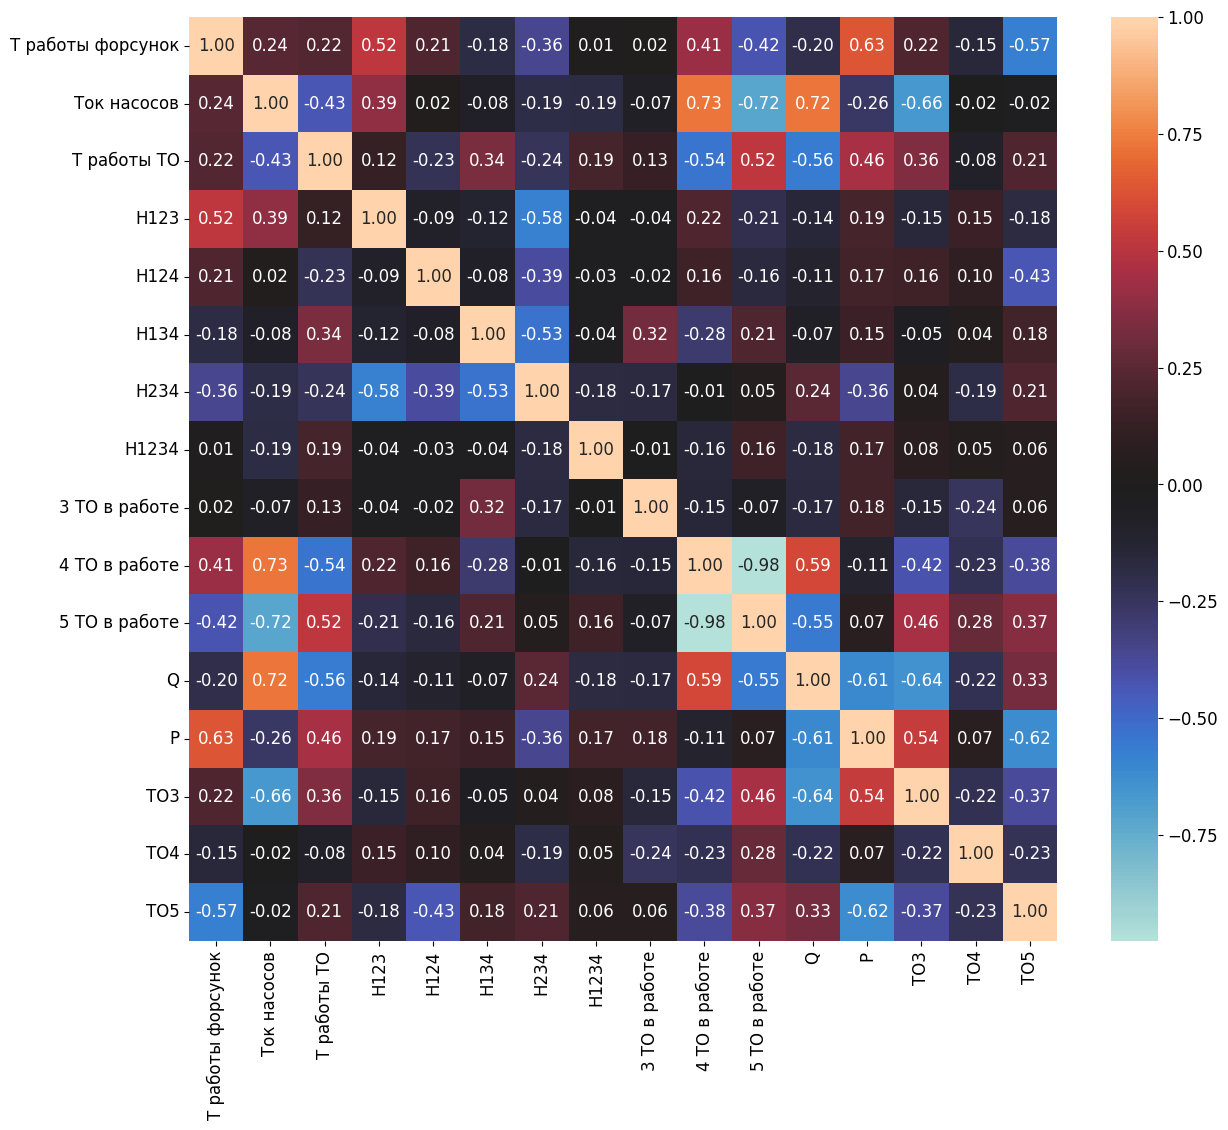

In [90]:
plt.figure(figsize=(14,12))
sns.heatmap(
    df_stats_Q2_heatmap.corr(method='spearman'), 
    annot=True, 
    fmt=".2f", 
    xticklabels=names, 
    yticklabels=names,
    center=0,
#     mask=mask
)
# plt.xticks(rotation=45)

In [91]:
from sklearn.multioutput import MultiOutputRegressor

In [92]:
X = df_stats_Q2.drop(["Q2", "P2"], axis=1)
y = df_stats_Q2[["Q2", "P2"]]

In [93]:
X.shape, y.shape

((81275, 8), (81275, 2))

In [94]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [96]:
pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    GradientBoostingRegressor()
).set_output(transform="pandas")


In [97]:
mor_pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    MultiOutputRegressor(HistGradientBoostingRegressor())
).set_output(transform="pandas")

mor_pl_1 = make_pipeline(
    ct,
    MultiOutputRegressor(KNeighborsRegressor())
).set_output(transform="pandas")

mor_pl_2 = make_pipeline(
    ct,
    MultiOutputRegressor(tree.DecisionTreeRegressor())
).set_output(transform="pandas")

In [98]:
# multioutput
mor_gbr = mor_pl.fit(X_train, y_train)
mor_pl_1.fit(X_train, y_train)
mor_pl_2.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP', 'I2mean',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2', 'HEs_num'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

0.9294994201867768
0.00044125736729224053


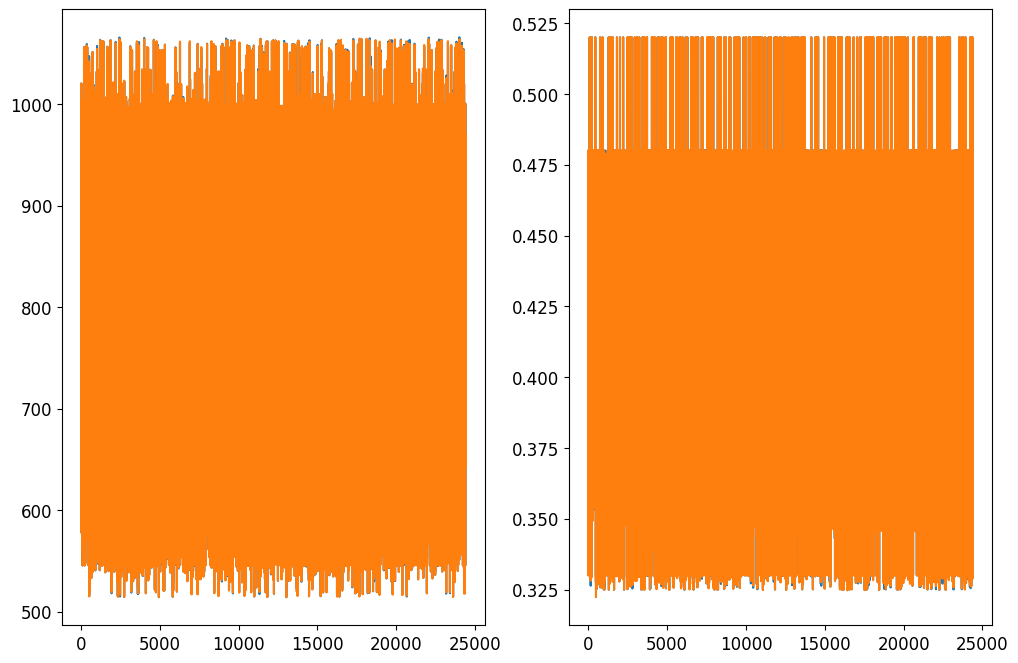

In [99]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_1.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_1.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

0.19436789209652638
0.00010731875768494863


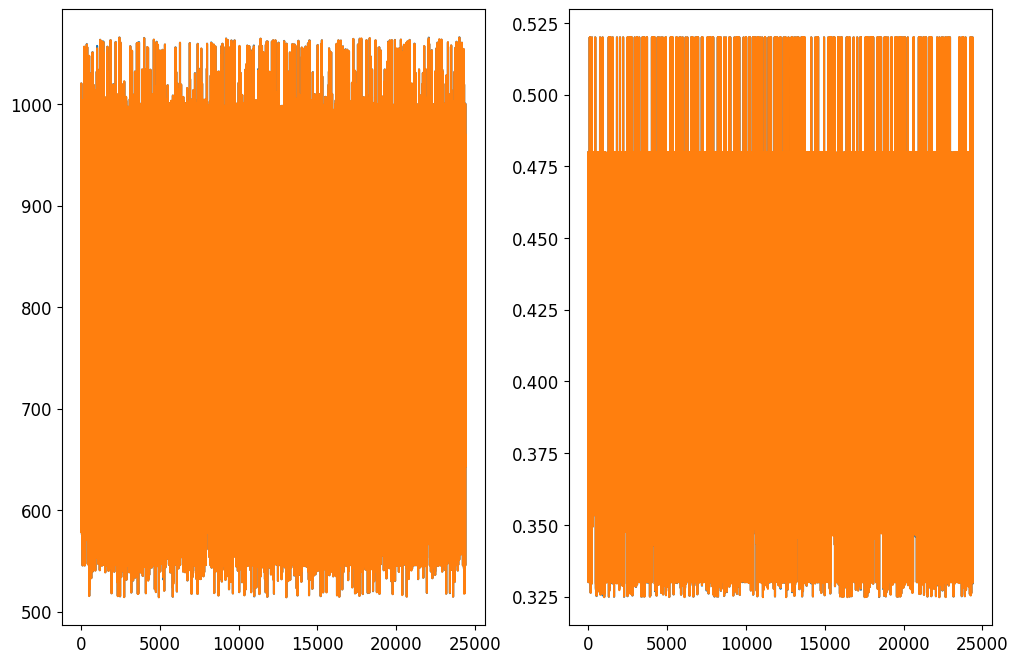

In [100]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_2.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_2.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

2.475934862072278
0.001351843727562362


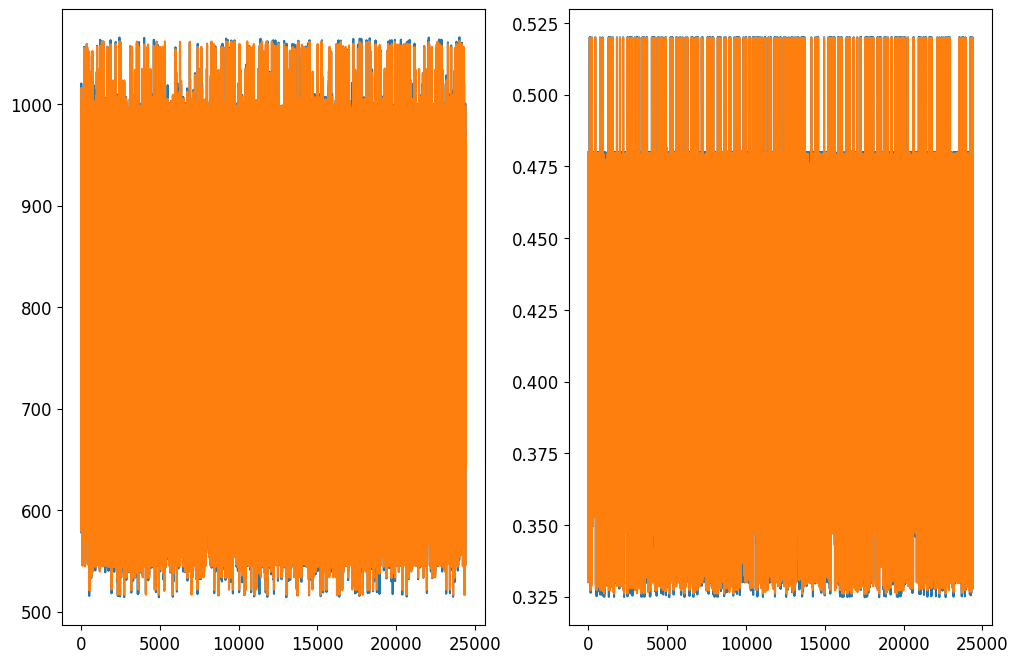

In [101]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0],
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0],
    errorbar=("pi", 100)
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_gbr.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_gbr.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

## USE of folds to predict

In [102]:
ss_folds = list(ShuffleSplit(n_splits=4).split(X,y))
k_folds = list(KFold(n_splits=4).split(X,y))

In [103]:
gbr_pl1 = pl

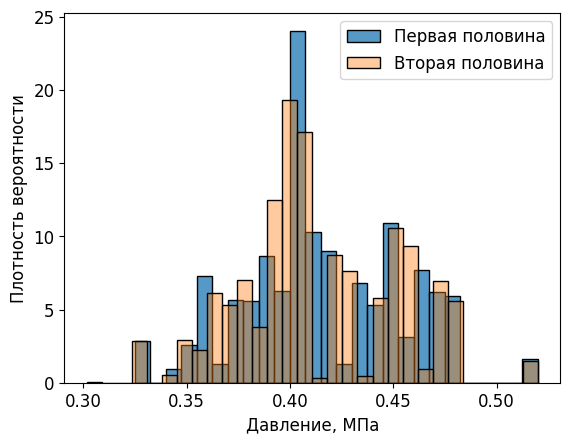

In [104]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

<AxesSubplot: xlabel='Q2', ylabel='Count'>

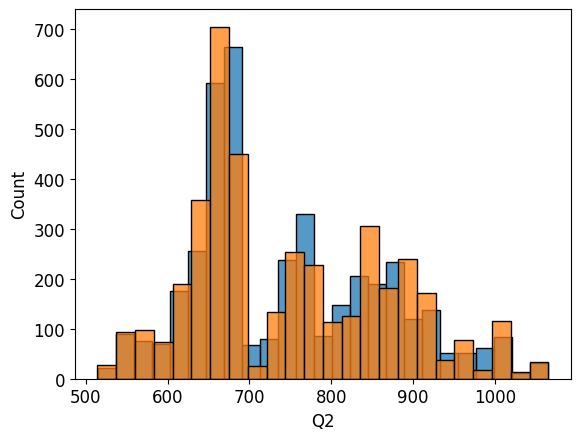

In [105]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["Q2"]
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["Q2"]
)

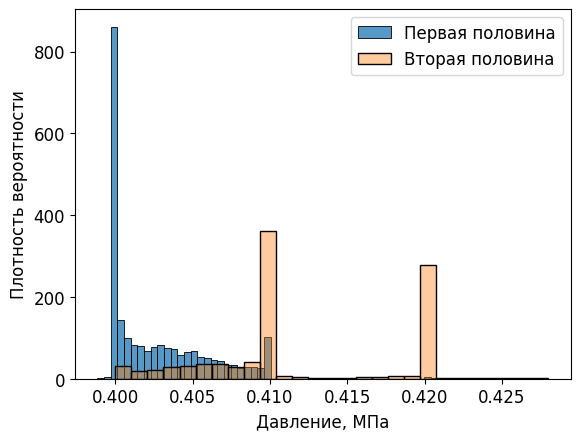

In [106]:
sns.histplot(
    y.iloc[
        k_folds[0][1][:int(len(k_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        k_folds[0][1][int(len(k_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.8121959803531635
15.47987450884673
single_pred 688.4950000000001 703.9748745088468 673.0151254911534 688.97
748.0289416060208 745.4378910146484 750.6199921973932


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.8400240495649586
16.819589700375992
single_pred 949.0710000000001 965.8905897003762 932.2514102996241 949.3050000000001
749.4960013837363 746.9382578806246 752.0537448868479


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.844877495631933
17.92435241787774
single_pred 895.097 913.0213524178777 877.1726475821223 895.6850000000001
748.7433907690673 746.174217986857 751.3125635512777


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7877353799689591
12.86832785063187
single_pred 833.6630000000001 846.531327850632 820.7946721493682 833.585
750.2232152905727 747.6538934103315 752.792537170814


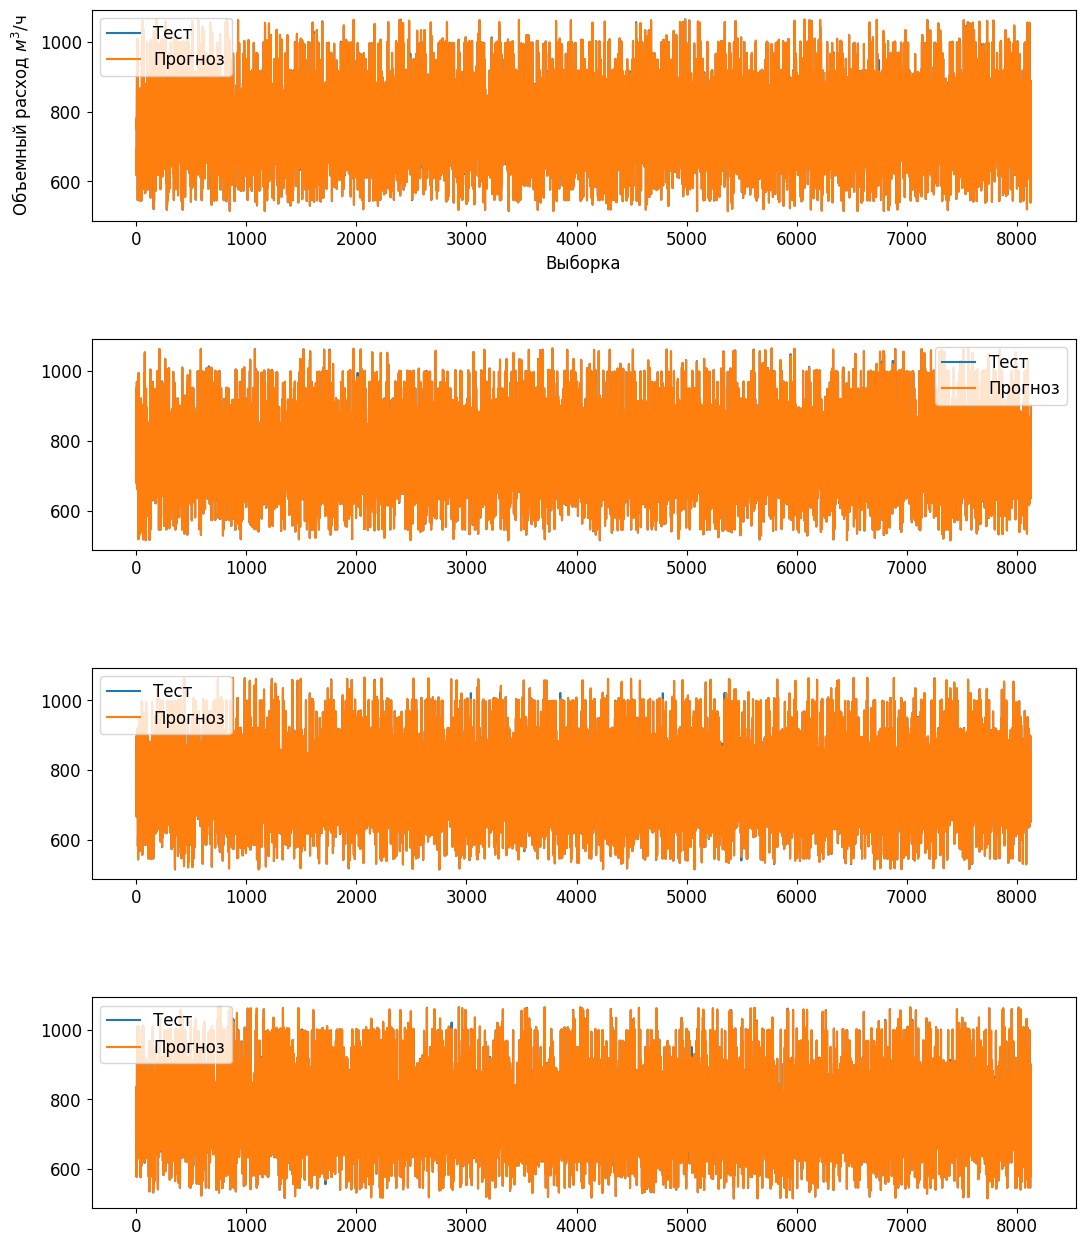

In [107]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,14))
fig.tight_layout(pad=5.0)

level = 1.96
# pred_intr_upper

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_1.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n],
        label="Тест"
    )
    
    pred = mor_pl_1.predict(
         X.iloc[te])[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n],
        label="Прогноз",
        errorbar="ci"
    )
    
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    print(interval)
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper, y.iloc[te].iloc[0]["Q2"]
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.16835127337222053
single_pred 689.0 691.5590968150891 686.4409031849109
748.0360054975506 745.4444723341729 750.6275386609283


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.17697933301498697
single_pred 949.235 952.2498077728441 946.220192227156
749.492723513822 746.9344499693842 752.0509970582599


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.1622564440187184
single_pred 895.7549999999999 897.2498862976959 894.2601137023039
748.7359333353119 746.1661666159819 751.3057000546419


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.19259141513599493
single_pred 833.5600000000001 837.1411022813098 829.9788977186903
750.2528542419151 747.6833540849286 752.8223543989016


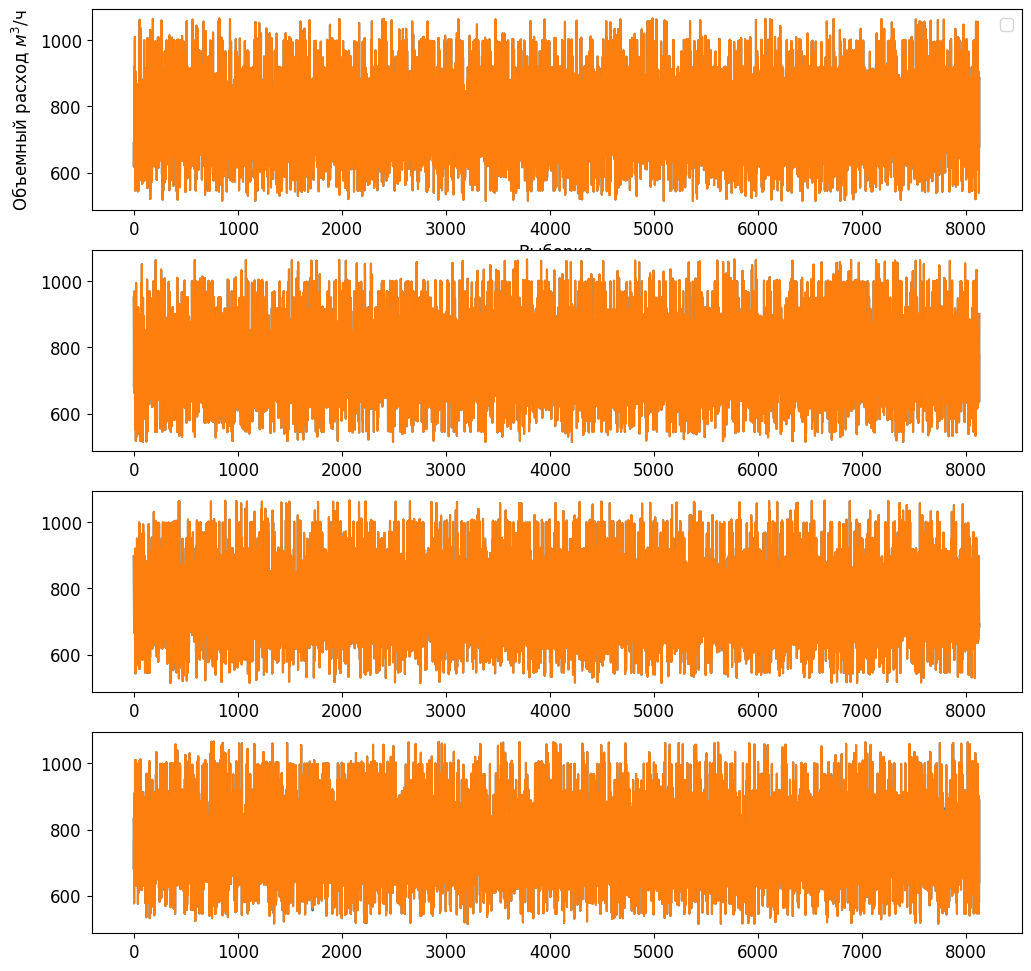

In [108]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_2.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_pl_2.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.5127951795590118
single_pred 685.798444561362 719.5155087386954 652.0813803840285
747.991214617061 745.4064977069536 750.5759315271684


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.706807454712149
single_pred 950.874184039477 992.9626472740897 908.7857208048642
749.5008917936897 746.9478278796704 752.053955707709


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.552639273974639
single_pred 893.9141345263102 930.2700068307944 857.5582622218261
748.7743657409832 746.2094383797427 751.3392931022237


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4627956832046234
single_pred 836.7782228689935 869.2241576065029 804.332288131484
750.390164327202 747.8245561755359 752.9557724788681


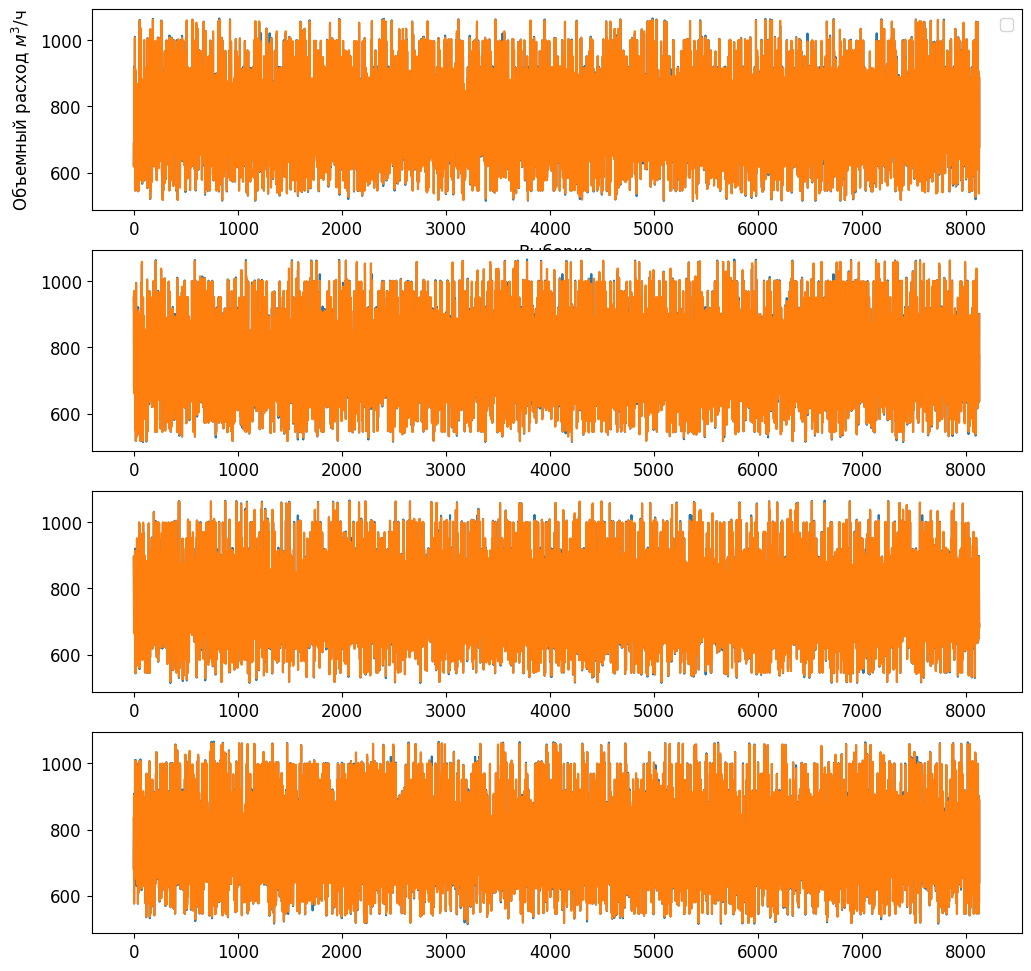

In [109]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_gbr.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_gbr.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

# Sort shuffled by indexes to make reverse transform and show results of prediction

In [110]:
tr0, te0 = ss_folds[0]

In [111]:
tr0.shape

(73147,)

In [112]:
te0_sorted = np.argsort(te0)

In [113]:
mor_pl_2.fit(
    X.iloc[tr0],
    y.iloc[tr0]
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP', 'I2mean',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2', 'HEs_num'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

In [114]:
mor_pl_2_toreverse = mor_pl_2.predict(X.iloc[te0])

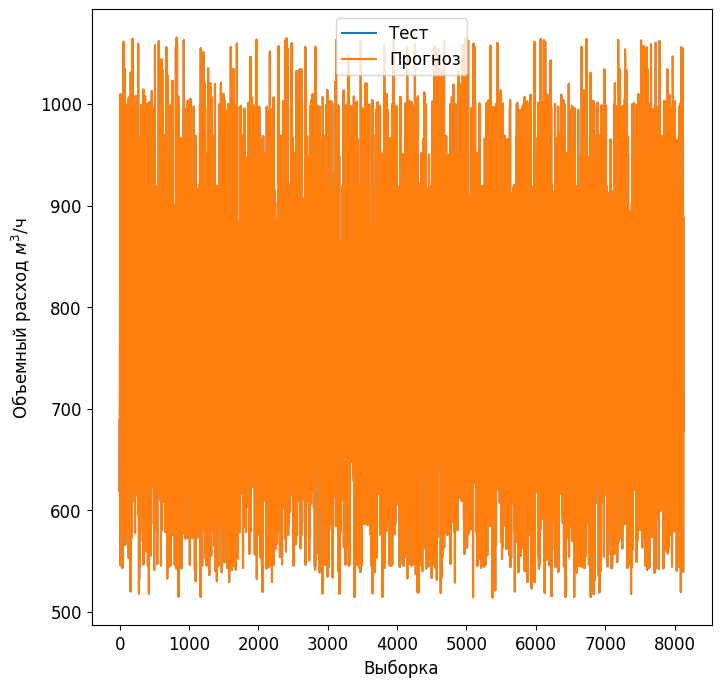

In [115]:
fig, ax = plt.subplots(figsize=(8,8))

sns.lineplot(y.iloc[te0]["Q2"].to_numpy(), label="Тест")
sns.lineplot(mor_pl_2_toreverse[:, 0], label="Прогноз")

plt.xlabel("Выборка")
plt.ylabel("Объемный расход $м^3$/ч")

plt.legend()

In [116]:
interval_toreverse = 1/( len(y.iloc[te0]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te0]["Q2"].to_numpy() - mor_pl_2_toreverse[:, 0] ) ** 2
        ) * level


In [117]:
lower_toreverse = mor_pl_2_toreverse[:, 0] - interval_toreverse
upper_toreverse = mor_pl_2_toreverse[:, 0] + interval_toreverse

In [118]:
lower_reversed = lower_toreverse[te0_sorted]
upper_reversed = upper_toreverse[te0_sorted]

In [119]:
lower_toreverse, upper_toreverse

(array([686.52871106, 615.58871106, 650.85371106, ..., 631.15871106,
        886.25371106, 675.94871106]),
 array([691.65128894, 620.71128894, 655.97628894, ..., 636.28128894,
        891.37628894, 681.07128894]))

In [120]:
mor_pl_2_Q2_reversed = mor_pl_2_toreverse[:, 0][te0_sorted]

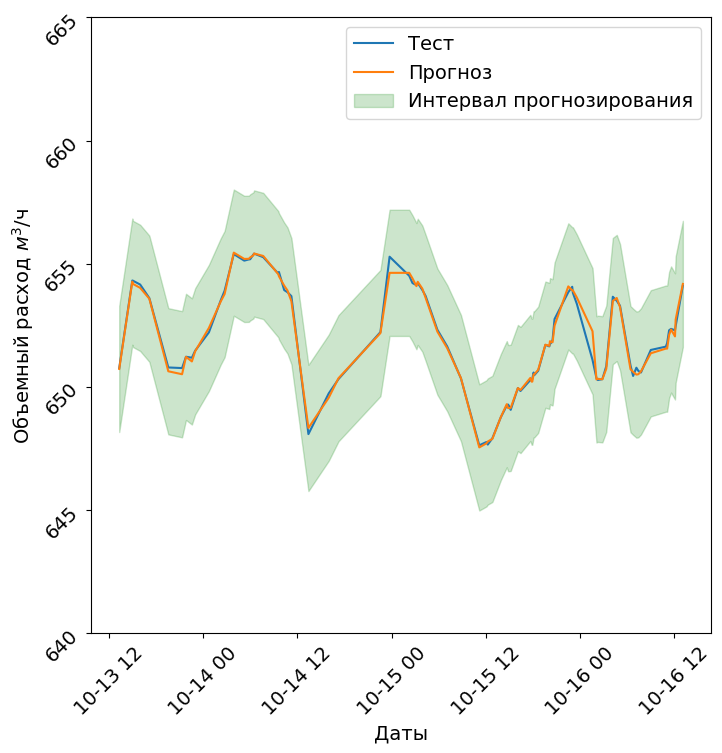

In [121]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(8,8))

start = 0
shift = 87
ind = y.index[te0[te0_sorted]][start:shift]

sns.lineplot(
    x=ind, 
    y=y.iloc[te0[te0_sorted]]["Q2"][start:shift], 
    ax=ax, 
#     color="red",
    label="Тест"
    
)

sns.lineplot(
    x=ind, 
    y=mor_pl_2_Q2_reversed[start:shift], 
    ax=ax,
    label="Прогноз"
)

ax.fill_between(
    x=ind, 
    y1=lower_reversed[start:shift],
    y2=upper_reversed[start:shift],
    alpha=0.2,
    color="green",
    label="Интервал прогнозирования"
)

ax.set_ylim(640,665)
ax.set_xlabel("Даты")
ax.set_ylabel("Объемный расход $м^3$/ч")
ax.tick_params(rotation=45)
ax.legend()

In [122]:
y.iloc[te0[te0_sorted]]

Q2      P2
Timestamp                           
2020-10-13 13:20:00  650.765  0.4000
2020-10-13 15:00:00  654.320  0.4000
2020-10-13 15:05:00  654.310  0.4000
2020-10-13 16:00:00  654.155  0.4000
2020-10-13 17:10:00  653.605  0.4000
...                      ...     ...
2023-06-09 16:30:00  798.180  0.4694
2023-06-09 16:45:00  798.345  0.4698
2023-06-09 17:25:00  798.820  0.4700
2023-06-09 18:05:00  798.635  0.4700
2023-06-09 18:25:00  798.285  0.4700

[8128 rows x 2 columns]

# The Decision Tree is the best model so far
# Saving it to a file

In [366]:

dump(mor_pl_2, "DT_Q2P2_v0.1.joblib")

# Now lets check how prediction accuracy may changes with feature elimination process

['DT_Q2P2_v0.1.joblib']

# Now lets check how prediction accuracy may changes with feature elimination process

In [123]:
from sklearn.metrics import PredictionErrorDisplay

In [124]:
mor_pl_2_whole = mor_pl_2.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [125]:
y_pred = mor_pl_2_whole.predict(X_test)

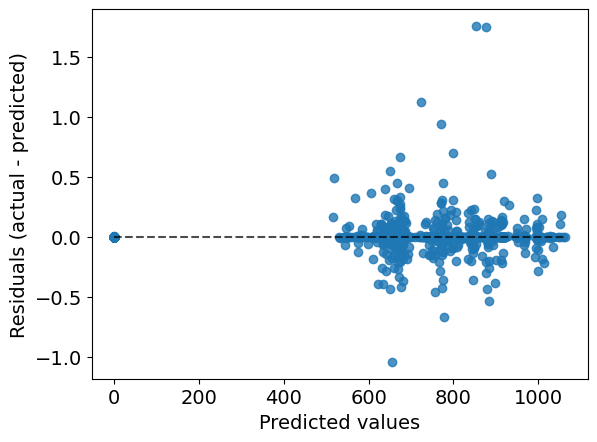

In [126]:
PredictionErrorDisplay.from_estimator(
    mor_pl_2_whole, 
    X, 
    y
)

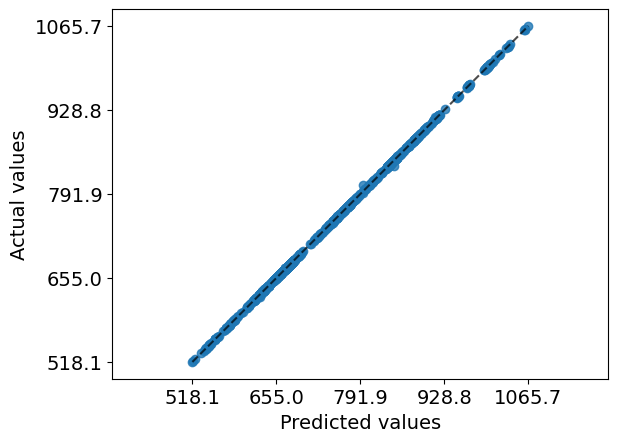

In [127]:
PredictionErrorDisplay.from_predictions(
    y_true=y_test["Q2"], 
    y_pred=y_pred[:, 0],
    kind="actual_vs_predicted"
)

NormaltestResult(statistic=2288.0169916710765, pvalue=0.0)

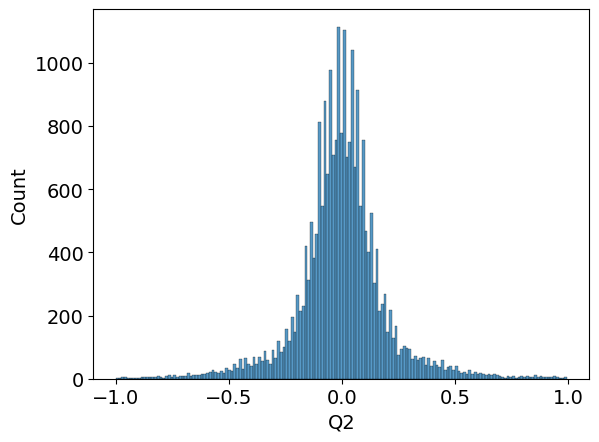

In [128]:
residuals = y_test["Q2"] - y_pred[:, 0]
sns.histplot(residuals[(residuals < 1) & (residuals > -1)])
scipy.stats.normaltest(residuals[(residuals < 1) & (residuals > -1)])

# Let's squeeze data by grouping by 1h 

In [1301]:
df_stats_1h = pd.read_excel("!important_input_files/rdy_for_stats_121020_090623_1h_freq.xlsx", index_col="Timestamp")

<AxesSubplot: xlabel='P2', ylabel='Count'>

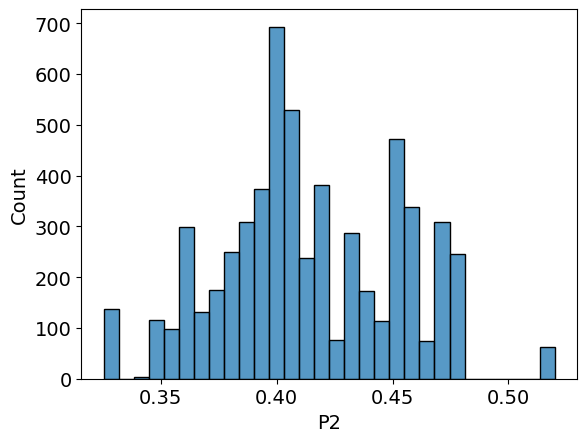

In [1302]:
sns.histplot(df_stats_1h["P2"])

(120.0, 150.64676574038054)

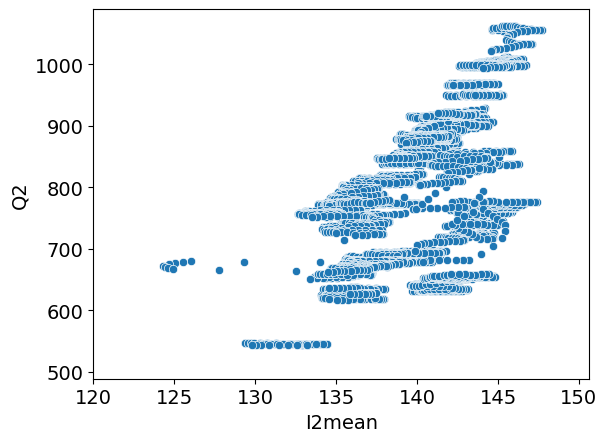

In [1405]:
sns.scatterplot(x=df_stats_1h["I2mean"], y=df_stats_1h["Q2"])
plt.xlim(120)

In [1303]:
df_stats_1h.shape

(5880, 35)

In [1304]:
fe_1h = FeatureEngineering(df_stats_1h)

In [1305]:
nozzles_periods = [
    ("2020-10-12", "2021-07-02"), 
    ("2021-09-06", "2023-06-09")
]
df_stats_1h = fe_1h.make_time_onpower_feature(
    time_periods=nozzles_periods,
    feature_name="Nozzles_TOP"
)

[3.32210526e+00 6.64421053e+00 9.96631579e+00 ... 6.30535579e+03
 6.30867789e+03 6.31200000e+03] 1900 1900
[3.86532663e+00 7.73065327e+00 1.15959799e+01 ... 1.53762693e+04
 1.53801347e+04 1.53840000e+04] 3980 3980


In [1306]:
df_stats_1h["HEs_num"] = df_stats_1h[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)

In [1307]:
df_stats_1h["HE_TOP_mean_nums"] = df_stats_1h["HE_TOP_mean"] /  df_stats_1h["HEs_num"]

In [1308]:
selection_cols_Q2 = [
        "Q2", "P2", "I2mean", "Nozzles_TOP", 
        "pumps2",
        "HE1_TOP",
        "HE2_TOP",
        "HE3_TOP",
        "HE4_TOP",
        "HE5_TOP",
        "HE1_status",
        "HE2_status",
        "HE4_status", 
        "HE5_status",
        "HE3_status"
    ]

In [1309]:
df_stats_Q2_1h = df_stats_1h.loc[
    :, 
    selection_cols_Q2
]

In [1310]:
numerical_cols = [
    "Nozzles_TOP", "I2mean", 
    "HE1_TOP",
    "HE2_TOP",
    "HE3_TOP",
    "HE4_TOP",
    "HE5_TOP",
]
ct = ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), numerical_cols),
            ("categorical_data", OneHotEncoder(sparse=False), ["pumps2"])
        ],
        remainder="passthrough"
).set_output(transform="pandas")

In [1311]:
X_1h = df_stats_Q2_1h.drop(["Q2", "P2"], axis=1)
y_1h = df_stats_Q2_1h[["Q2", "P2"]]

In [1312]:
X_ct_1h = ct.fit_transform(X_1h)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1313]:
X_train1h, X_test1h, y_train1h, y_test1h = train_test_split(X_ct_1h, y_1h, test_size=0.3)

In [1314]:
DT_1h = MultiOutputRegressor(tree.DecisionTreeRegressor()).fit(X_train1h, y_train1h)

In [1315]:
Q2_1h_pred = DT_1h.predict(X_test1h)[:, 0]
P2_1h_pred = DT_1h.predict(X_test1h)[:, 1]

0.9981387718620494

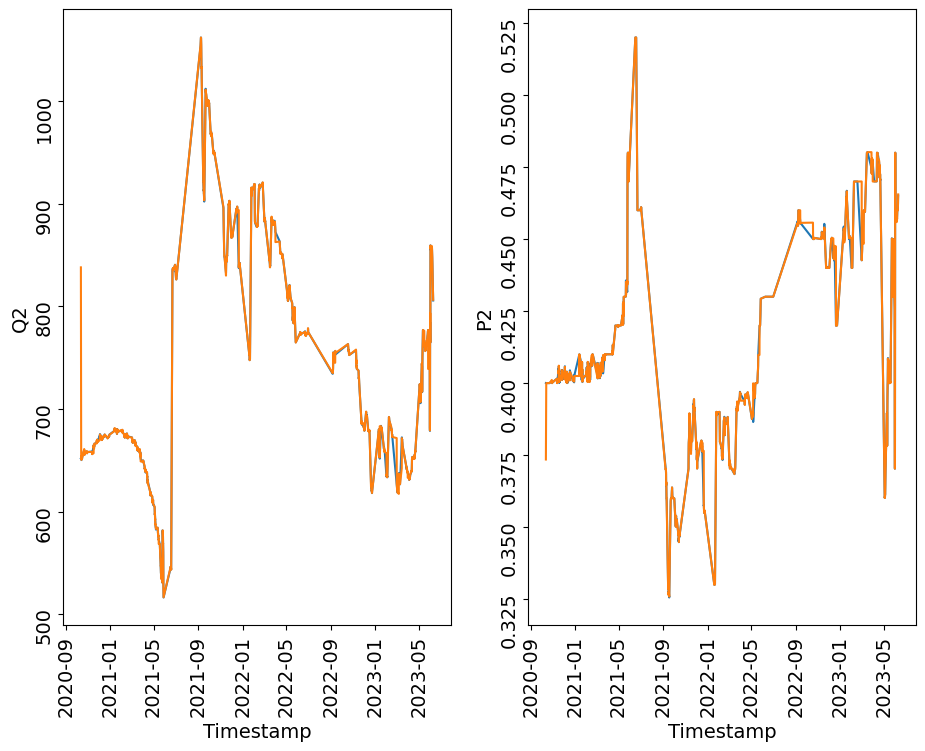

In [1316]:
fig, axs = plt.subplots(1,2, figsize=(11,8))

sns.lineplot(
    y_test1h["Q2"],
    ax=axs[0]
)
sns.lineplot(
    x=y_test1h.index,
    y=Q2_1h_pred,
    ax=axs[0]
    
)

sns.lineplot(
    y_test1h["P2"],
    ax=axs[1]
)
sns.lineplot(
    x=y_test1h.index,
    y=P2_1h_pred,
    ax=axs[1]
    
)

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

DT_1h.score(X_test1h, y_test1h)

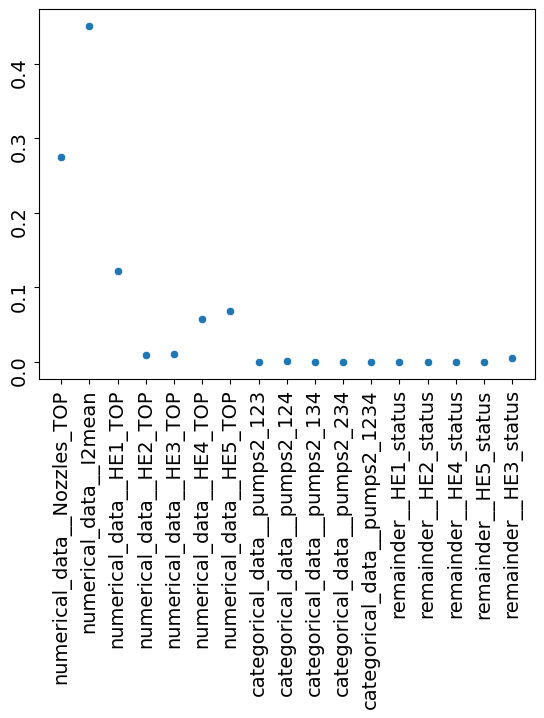

In [1318]:
sns.scatterplot(y=tree.DecisionTreeRegressor().fit(X_train1h, y_train1h["Q2"]).feature_importances_, x=X_ct_1h.columns)
plt.tick_params(rotation=90)

# Upload new data

In [1319]:
df_new = pd.read_csv("050923_2nd_circuit.csv")

In [1320]:
prep_csv = CsvRefactorer(df_new)

In [1321]:
ids = prep_csv.select_by_ids(prep_csv.ids)

In [1322]:
group = prep_csv.min_frac_groupby(30, *ids)

In [1323]:
df_new = prep_csv.concat_dfs(group)

In [1324]:
df_new = df_new.rename(columns=prep_csv.IDS_MAP)

<AxesSubplot: xlabel='Timestamp', ylabel='Q2'>

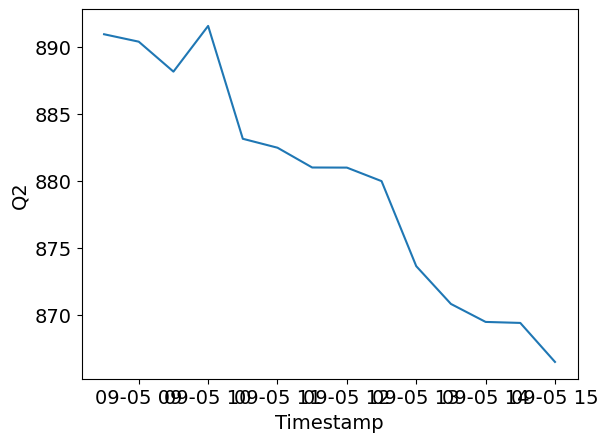

In [1325]:
sns.lineplot(df_new["Q2"])

In [1326]:
# df_new_to_test = df_new.loc[:, ["P2", "Q2", "p21", "p22", "p23", "p24"]]

In [1327]:
fe_new = FeatureEngineering(df_new)

In [1328]:
fe_new.filter_by_zscore(column="Q2")

Q2


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-05 08:30:00  40.857692  0.400500  45.739240  29.450725  33.471429   
2023-09-05 09:00:00  42.760377  0.400000  47.804630  30.761321  34.989524   
2023-09-05 09:30:00  44.708824  0.400000  50.825234  30.137383  35.317476   
2023-09-05 10:00:00  44.691579  0.397742  51.141237  28.885148  34.395049   
2023-09-05 10:30:00  44.404124  0.400000  50.890323  28.426804  34.031959   
2023-09-05 11:00:00  44.048913  0.400000  50.553124  28.015958  33.619565   
2023-09-05 11:30:00  43.831868  0.400000  50.324731  27.845454  33.431960   
2023-09-05 12:00:00  43.759341  0.400000  50.274193  27.721783  33.332653   
2023-09-05 12:30:00  43.692392  0.400000  50.246392  27.672728  33.298936   
2023-09-05 13:00:00  43.623655  0.400000  50.179348  27.614424  33.265625   
2023-09-05 13:30:00  43.567032  0.400000  50.158696  27.477320  33.152174   
2023-09-05 14:00:00  43.488044  0.400000  50.081317  27.397894  33.085105   
2023-09-05 14:30:00  43.463044  0.400000  50.049999  27.425773  33.095651   
2023-09-05 15:00:00  43.489011  0.400000  50.099998  27.379591  33.084614   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-05 08:30:00  41.472500  33.902941  14.294805  0.030766  142.866758   
2023-09-05 09:00:00  43.528448  35.437736  14.805932  0.000000  142.313542   
2023-09-05 09:30:00  46.410811  35.880392  16.256780  1.580323  140.533770   
2023-09-05 10:00:00  46.616964  35.042308  18.641176  0.993253  140.078531   
2023-09-05 10:30:00  46.295575  34.672165  19.441025  0.084533  139.724615   
2023-09-05 11:00:00  46.068965  34.274000  19.788793  0.125866  139.576859   
2023-09-05 11:30:00  46.026956  34.108420  20.681897  1.112286  140.307453   
2023-09-05 12:00:00  45.949107  34.005941  19.661865  2.016971  141.189984   
2023-09-05 12:30:00  45.965218  33.964706  18.866957  0.000000  140.267759   
2023-09-05 13:00:00  45.902565  33.944118  19.740517  1.588639  140.581587   
2023-09-05 13:30:00  45.893221  33.847873  18.924138  3.547395  140.241506   
2023-09-05 14:00:00  45.877877  33.785567  19.817699  0.000000  140.019680   
2023-09-05 14:30:00  45.826725  33.810309  19.658407  3.610036  140.255737   
2023-09-05 15:00:00  45.852137  33.800000  20.119643  3.320936  140.232475   

                            p23         p24     T2aHE2     T2aHE3     T2aHE4  \
Timestamp                                                                      
2023-09-05 08:30:00  141.162499  145.436935  33.804569  33.323688  20.480788   
2023-09-05 09:00:00  140.986958  145.366919  35.325088  34.830422  20.767632   
2023-09-05 09:30:00  140.814034  145.134092  35.674484  35.046645  21.141995   
2023-09-05 10:00:00  140.851415  144.971821  34.875031  34.106728  21.538133   
2023-09-05 10:30:00  140.274349  144.481389  34.514845  33.717110  21.927713   
2023-09-05 11:00:00  140.169986  144.348741  34.104442  33.305605  22.299481   
2023-09-05 11:30:00  140.377763  144.432700  33.922976  33.123702  22.662904   
2023-09-05 12:00:00  141.065094  144.898816  33.837617  33.027879  23.010739   
2023-09-05 12:30:00  140.711494  144.495301  33.798407  32.976974  23.338704   
2023-09-05 13:00:00  139.070354  144.440738  33.776311  32.943935  23.655745   
2023-09-05 13:30:00  137.875600  144.318165  33.690566  32.841405  23.965296   
2023-09-05 14:00:00  137.761046  144.137027  33.616628  32.758755  24.246890   
2023-09-05 14:30:00  137.907399  144.281926  33.638337  32.775149  24.527552   
2023-09-05 15:00:00  137.779243  144.298810  33.646584  32.765548  24.798350   

                        T2aHE5          Q2  dt_circuits_coef  \
Timestamp                                                      
2023-09-05 08:30:00  33.188289  890.937500          1.553077   
2023-09-05 09:00:00  34.659338  890.383333          1.554050   
2023-0

In [1329]:
fe_new.df = fe_new.df.rolling(6).mean().dropna()

In [1330]:
fe_new.df["pumps2"] = np.full(shape=len(fe.df), fill_value=234)

In [1331]:
fe_new.columns_averaging(columns=["p21", "p22", "p23", "p24"], omitbelow=50, feature_name="I2mean")

['p21', 'p22', 'p23', 'p24']


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-05 11:00:00  43.578585  0.399707  49.492298  29.279556  34.304167   
2023-09-05 11:30:00  44.074281  0.399624  50.256546  29.012011  34.297589   
2023-09-05 12:00:00  44.240775  0.399624  50.668140  28.505422  34.021444   
2023-09-05 12:30:00  44.071369  0.399624  50.571667  28.094646  33.685020   
2023-09-05 13:00:00  43.893382  0.400000  50.411352  27.882858  33.496783   
2023-09-05 13:30:00  43.753867  0.400000  50.289414  27.724611  33.350152   
2023-09-05 14:00:00  43.660389  0.400000  50.210780  27.621600  33.261075   
2023-09-05 14:30:00  43.598918  0.400000  50.164991  27.551653  33.205024   
2023-09-05 15:00:00  43.553863  0.400000  50.135958  27.494622  33.163684   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-05 11:00:00  45.065544  34.868257  17.204752  0.469123  140.849012   
2023-09-05 11:30:00  45.824620  34.902503  18.269267  0.649377  140.422461   
2023-09-05 12:00:00  46.228063  34.663871  19.078589  0.985539  140.235202   
2023-09-05 12:30:00  46.153798  34.344590  19.513619  0.722151  140.190867   
2023-09-05 13:00:00  46.034731  34.161558  19.696842  0.821382  140.274709   
2023-09-05 13:30:00  45.967672  34.024176  19.610694  1.398526  140.360858   
2023-09-05 14:00:00  45.935824  33.942771  19.615512  1.377548  140.434662   
2023-09-05 14:30:00  45.902452  33.893086  19.444930  1.793840  140.426042   
2023-09-05 15:00:00  45.886290  33.858762  19.521227  2.011168  140.266457   

                     ...         p24     T2aHE2     T2aHE3     T2aHE4  \
Timestamp            ...                                                
2023-09-05 11:00:00  ...  144.956649  34.716410  34.055033  21.359290   
2023-09-05 11:30:00  ...  144.789277  34.736144  34.021702  21.722976   
2023-09-05 12:00:00  ...  144.711260  34.488233  33.721278  22.096827   
2023-09-05 12:30:00  ...  144.604795  34.175553  33.376333  22.462946   
2023-09-05 13:00:00  ...  144.516281  33.992433  33.182534  22.815881   
2023-09-05 13:30:00  ...  144.489077  33.855053  33.036583  23.155478   
2023-09-05 14:00:00  ...  144.453791  33.773751  32.945442  23.480046   
2023-09-05 14:30:00  ...  144.428662  33.726311  32.887349  23.790821   
2023-09-05 15:00:00  ...  144.328661  33.694472  32.843628  24.088756   

                        T2aHE5          Q2  dt_circuits_coef  \
Timestamp                                                      
2023-09-05 11:00:00  33.870009  887.774306          1.693124   
2023-09-05 11:30:00  33.828075  886.118056          1.735492   
2023-09-05 12:00:00  33.523496  884.552778          1.778739   
2023-09-05 12:30:00  33.181629  883.191667          1.800286   
2023-09-05 13:00:00  32.986833  880.205556          1.808059   
2023-09-05 13:30:00  32.838937  878.152778          1.813932   
2023-09-05 14:00:00  32.743155  875.987500          1.817846   
2023-09-05 14:30:00  32.679966  874.055556          1.820786   
2023-09-05 15:00:00  32.631337  871.640278          1.823503   

                     dt_circuits_coef_delta  pumps2      I2mean  
Timestamp                                                        
2023-09-05 11:00:00               20.212742     234  142.171845  
2023-09-05 11:30:00               21.244535     234  141.930274  
2023-09-05 12:00:00               22.162719     234  141.846189  
2023-09-05 12:30:00               22.477021     234  141.790226  
2023-09-05 13:00:00               22.528494     234  141.689721  
2023-09-05 13:30:00               22.564803     234  141.576106  
2023-09-05 14:00:00               22.589179     234  141.455115  
2023-09-05 14:30:00               22.613337     234  141.306623  
2023-09-05 15:00:00               22.641337     234  141.037547  

[9 rows x 21 columns]

In [1332]:
st = 0

period = [("2023-09-04", "2023-09-05")]

fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE1_TOP", start=st
)

fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE2_TOP", start=st
)

fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE3_TOP", start=st
)

fe_new.df["HE4_TOP"] = np.zeros(len(fe.df))


fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE5_TOP", start=(912+st)
)

[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9
[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9
[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9
[914.66666667 917.33333333 920.         922.66666667 925.33333333
 928.         930.66666667 933.33333333 936.        ] 9 9


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-05 11:00:00  43.578585  0.399707  49.492298  29.279556  34.304167   
2023-09-05 11:30:00  44.074281  0.399624  50.256546  29.012011  34.297589   
2023-09-05 12:00:00  44.240775  0.399624  50.668140  28.505422  34.021444   
2023-09-05 12:30:00  44.071369  0.399624  50.571667  28.094646  33.685020   
2023-09-05 13:00:00  43.893382  0.400000  50.411352  27.882858  33.496783   
2023-09-05 13:30:00  43.753867  0.400000  50.289414  27.724611  33.350152   
2023-09-05 14:00:00  43.660389  0.400000  50.210780  27.621600  33.261075   
2023-09-05 14:30:00  43.598918  0.400000  50.164991  27.551653  33.205024   
2023-09-05 15:00:00  43.553863  0.400000  50.135958  27.494622  33.163684   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-05 11:00:00  45.065544  34.868257  17.204752  0.469123  140.849012   
2023-09-05 11:30:00  45.824620  34.902503  18.269267  0.649377  140.422461   
2023-09-05 12:00:00  46.228063  34.663871  19.078589  0.985539  140.235202   
2023-09-05 12:30:00  46.153798  34.344590  19.513619  0.722151  140.190867   
2023-09-05 13:00:00  46.034731  34.161558  19.696842  0.821382  140.274709   
2023-09-05 13:30:00  45.967672  34.024176  19.610694  1.398526  140.360858   
2023-09-05 14:00:00  45.935824  33.942771  19.615512  1.377548  140.434662   
2023-09-05 14:30:00  45.902452  33.893086  19.444930  1.793840  140.426042   
2023-09-05 15:00:00  45.886290  33.858762  19.521227  2.011168  140.266457   

                     ...          Q2  dt_circuits_coef  \
Timestamp            ...                                 
2023-09-05 11:00:00  ...  887.774306          1.693124   
2023-09-05 11:30:00  ...  886.118056          1.735492   
2023-09-05 12:00:00  ...  884.552778          1.778739   
2023-09-05 12:30:00  ...  883.191667          1.800286   
2023-09-05 13:00:00  ...  880.205556          1.808059   
2023-09-05 13:30:00  ...  878.152778          1.813932   
2023-09-05 14:00:00  ...  875.987500          1.817846   
2023-09-05 14:30:00  ...  874.055556          1.820786   
2023-09-05 15:00:00  ...  871.640278          1.823503   

                     dt_circuits_coef_delta  pumps2      I2mean    HE1_TOP  \
Timestamp                                                                    
2023-09-05 11:00:00               20.212742     234  142.171845   2.666667   
2023-09-05 11:30:00               21.244535     234  141.930274   5.333333   
2023-09-05 12:00:00               22.162719     234  141.846189   8.000000   
2023-09-05 12:30:00               22.477021     234  141.790226  10.666667   
2023-09-05 13:00:00               22.528494     234  141.689721  13.333333   
2023-09-05 13:30:00               22.564803     234  141.576106  16.000000   
2023-09-05 14:00:00               22.589179     234  141.455115  18.666667   
2023-09-05 14:30:00               22.613337     234  141.306623  21.333333   
2023-09-05 15:00:00               22.641337     234  141.037547  24.000000   

                       HE2_TOP    HE3_TOP  HE4_TOP     HE5_TOP  
Timestamp                                                       
2023-09-05 11:00:00   2.666667   2.666667      0.0  914.666667  
2023-09-05 11:30:00   5.333333   5.333333      0.0  917.333333  
2023-09-05 12:00:00   8.000000   8.000000      0.0  920.000000  
2023-09-05 12:30:00  10.666667  10.666667      0.0  922.666667  
2023-09-05 13:00:00  13.333333  13.333333      0.0  925.333333  
2023-09-05 13:30:00  16.000000  16.000000      0.0  928.000000  
2023-09-05 14:00:00  18.666667  18.666667      0.0  930.666667  
2023-09-05 14:30:00  21.333333  21.333333      0.0  933.333333  
2023-09-05 15:00:00  24.000000  24.000000      0.0  936.000000  

[9 rows x 26 columns]

In [1333]:
fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="Nozzles_TOP", start=0
)

[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-05 11:00:00  43.578585  0.399707  49.492298  29.279556  34.304167   
2023-09-05 11:30:00  44.074281  0.399624  50.256546  29.012011  34.297589   
2023-09-05 12:00:00  44.240775  0.399624  50.668140  28.505422  34.021444   
2023-09-05 12:30:00  44.071369  0.399624  50.571667  28.094646  33.685020   
2023-09-05 13:00:00  43.893382  0.400000  50.411352  27.882858  33.496783   
2023-09-05 13:30:00  43.753867  0.400000  50.289414  27.724611  33.350152   
2023-09-05 14:00:00  43.660389  0.400000  50.210780  27.621600  33.261075   
2023-09-05 14:30:00  43.598918  0.400000  50.164991  27.551653  33.205024   
2023-09-05 15:00:00  43.553863  0.400000  50.135958  27.494622  33.163684   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-05 11:00:00  45.065544  34.868257  17.204752  0.469123  140.849012   
2023-09-05 11:30:00  45.824620  34.902503  18.269267  0.649377  140.422461   
2023-09-05 12:00:00  46.228063  34.663871  19.078589  0.985539  140.235202   
2023-09-05 12:30:00  46.153798  34.344590  19.513619  0.722151  140.190867   
2023-09-05 13:00:00  46.034731  34.161558  19.696842  0.821382  140.274709   
2023-09-05 13:30:00  45.967672  34.024176  19.610694  1.398526  140.360858   
2023-09-05 14:00:00  45.935824  33.942771  19.615512  1.377548  140.434662   
2023-09-05 14:30:00  45.902452  33.893086  19.444930  1.793840  140.426042   
2023-09-05 15:00:00  45.886290  33.858762  19.521227  2.011168  140.266457   

                     ...  dt_circuits_coef  dt_circuits_coef_delta  pumps2  \
Timestamp            ...                                                     
2023-09-05 11:00:00  ...          1.693124               20.212742     234   
2023-09-05 11:30:00  ...          1.735492               21.244535     234   
2023-09-05 12:00:00  ...          1.778739               22.162719     234   
2023-09-05 12:30:00  ...          1.800286               22.477021     234   
2023-09-05 13:00:00  ...          1.808059               22.528494     234   
2023-09-05 13:30:00  ...          1.813932               22.564803     234   
2023-09-05 14:00:00  ...          1.817846               22.589179     234   
2023-09-05 14:30:00  ...          1.820786               22.613337     234   
2023-09-05 15:00:00  ...          1.823503               22.641337     234   

                         I2mean    HE1_TOP    HE2_TOP    HE3_TOP  HE4_TOP  \
Timestamp                                                                   
2023-09-05 11:00:00  142.171845   2.666667   2.666667   2.666667      0.0   
2023-09-05 11:30:00  141.930274   5.333333   5.333333   5.333333      0.0   
2023-09-05 12:00:00  141.846189   8.000000   8.000000   8.000000      0.0   
2023-09-05 12:30:00  141.790226  10.666667  10.666667  10.666667      0.0   
2023-09-05 13:00:00  141.689721  13.333333  13.333333  13.333333      0.0   
2023-09-05 13:30:00  141.576106  16.000000  16.000000  16.000000      0.0   
2023-09-05 14:00:00  141.455115  18.666667  18.666667  18.666667      0.0   
2023-09-05 14:30:00  141.306623  21.333333  21.333333  21.333333      0.0   
2023-09-05 15:00:00  141.037547  24.000000  24.000000  24.000000      0.0   

                        HE5_TOP  Nozzles_TOP  
Timestamp                                     
2023-09-05 11:00:00  914.666667     2.666667  
2023-09-05 11:30:00  917.333333     5.333333  
2023-09-05 12:00:00  920.000000     8.000000  
2023-09-05 12:30:00  922.666667    10.666667  
2023-09-05 13:00:00  925.333333    13.333333  
2023-09-05 13:30:00  928.000000    16.000000  
2023-09-05 14:00:00  930.666667    18.666667  
2023-09-05 14:30:00  933.333333    21.333333  
2023-09-05 15:00:00  936.000000    24.000000  

[9 rows x 27 columns]

In [1334]:
fe_new.df["HE1_status"] = np.zeros(len(fe.df))
fe_new.df["HE2_status"] = np.zeros(len(fe.df))
fe_new.df["HE3_status"] = np.zeros(len(fe.df))
fe_new.df["HE4_status"] = np.zeros(len(fe.df))
fe_new.df["HE5_status"] = np.zeros(len(fe.df))

In [1335]:
fe_new.df.loc[:, "HE1_status"][fe.df.loc[:, "HE1_TOP"] != 0] = 1

fe_new.df.loc[:, "HE2_status"][fe.df.loc[:, "HE2_TOP"] != 0] = 1

fe_new.df.loc[:, "HE3_status"][fe.df.loc[:, "HE3_TOP"] != 0] = 1

fe_new.df.loc[:, "HE4_status"][fe.df.loc[:, "HE4_TOP"] != 0] = 1

fe_new.df.loc[:, "HE5_status"][fe.df.loc[:, "HE5_TOP"] != 0] = 1

/tmp/ipykernel_4067/2658666064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE1_status"][fe.df.loc[:, "HE1_TOP"] != 0] = 1
/tmp/ipykernel_4067/2658666064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE2_status"][fe.df.loc[:, "HE2_TOP"] != 0] = 1
/tmp/ipykernel_4067/2658666064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE3_status"][fe.df.loc[:, "HE3_TOP"] != 0]

In [1336]:
fe_new.df["HE_TOP_mean_nums"] = fe_new.df.loc[:, ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]].mean(axis=1) / fe.df.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)

In [1337]:
fe_new.df["HE_TOP_mean"] = fe_new.df.loc[:, ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]].mean(axis=1)

In [1338]:
df_new_to_test = fe_new.df.loc[
    :, 
    selection_cols_Q2
]

In [1339]:
df_new_to_test.mean(), df_new[["Q2", "P2"]].mean()

(Q2             880.186497
 P2               0.399842
 I2mean         141.644850
 Nozzles_TOP     13.333333
 pumps2         234.000000
 HE1_TOP         13.333333
 HE2_TOP         13.333333
 HE3_TOP         13.333333
 HE4_TOP          0.000000
 HE5_TOP        925.333333
 HE1_status       1.000000
 HE2_status       1.000000
 HE4_status       0.000000
 HE5_status       1.000000
 HE3_status       1.000000
 dtype: float64,
 Q2    879.891369
 P2      0.399874
 dtype: float64)

In [1340]:
df_new_to_test_aver = df_new_to_test.mean(axis=0)

In [1341]:
df_new_to_test_aver = pd.DataFrame(data=df_new_to_test_aver.to_numpy().reshape(1,-1), index=[0], columns=df_new_to_test_aver.index)

In [1342]:
inp = ct.transform(df_new_to_test_aver)

In [1343]:
inp

numerical_data__Nozzles_TOP  numerical_data__I2mean  \
0                    -1.428671                0.730857   

   numerical_data__HE1_TOP  numerical_data__HE2_TOP  numerical_data__HE3_TOP  \
0                -1.277529                -1.277529                -0.942436   

   numerical_data__HE4_TOP  numerical_data__HE5_TOP  \
0                 -1.12483                -0.234352   

   categorical_data__pumps2_123  categorical_data__pumps2_124  \
0                           0.0                           0.0   

   categorical_data__pumps2_134  categorical_data__pumps2_234  \
0                           0.0                           1.0   

   categorical_data__pumps2_1234  remainder__HE1_status  \
0                            0.0                    1.0   

   remainder__HE2_status  remainder__HE4_status  remainder__HE5_status  \
0                    1.0                    0.0                    1.0   

   remainder__HE3_status  
0                    1.0

In [1374]:
DT_1h.predict(inp)

array([[1.05707042e+03, 3.28603783e-01]])

In [1375]:
DT_1h.predict(inp)[0] / df_new[["Q2", "P2"]].mean()

Q2    1.201365
P2    0.821767
dtype: float64

In [1400]:
d = {
        "Nozzles_TOP" : 10,
        "I2mean" : 145,
        "pumps2" : 234,
        "HE1_TOP" : 500,
        "HE2_TOP" : 500,
        "HE3_TOP" : 500,
        "HE4_TOP" : 0,
        "HE5_TOP" : 1400,
        "HE1_status": 1,
        "HE2_status": 1,
        "HE3_status": 1,
        "HE4_status": 0,
        "HE5_status": 1,
    
}

In [1401]:
inp2 = pd.DataFrame(
    d,
    index=[0]
)

In [1402]:
inp2 = ct.transform(inp2)

In [1403]:
DT_1h.predict(inp2)

array([[1.04465463e+03, 3.64719784e-01]])